## The goal: Now that we have some maps of global wind variances from CLUBB, can we get interesting regions to focus on? 
<br>
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 20 Aug 2020 <br>

In [1]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import Ngl
import numpy
import Nio
import os
import numpy as np 
import xarray as xr
import datetime
from datetime import date, timedelta
import pandas as pd 
import regionmask
import pickle


## Read in data

In [2]:
# Set up directories 
dataDir    = '/Users/meganfowler/Documents/NCAR/Analysis/CLUBB_initial/data/'
nameStart  = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.'
nameEnd    = '_CLUBBwinds.nc'
nameEnd_UV = '_UV.nc'
nameEnd_W  = '_W.nc'

decadeList = ['1951-59','1960-69', '1970-79','1980-89','1990-99','2000-14']


In [3]:
# Read in example file to get some constant fields
testName = dataDir+nameStart+'1990-01.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
lat = testDF.lat
lon = testDF.lon

# Make land mask
landFrac = np.squeeze(testDF.LANDFRAC.values)
# Define as 'land' gridcell if land fraction > 0.5
landMask = np.full([len(lat),len(lon)],np.nan)
landMask[landFrac > 0.5] = 1


In [4]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 
    fileName = dataDir+nameStart+decadeList[iDec]+nameEnd
    dataDF   = xr.open_dataset(fileName, decode_times=True)
    dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    UVfile = dataDir+nameStart+decadeList[iDec]+nameEnd_UV 
    windDF = xr.open_dataset(UVfile, decode_times=True)
    windDF['time'] = windDF.indexes['time'].to_datetimeindex()
    
    Wfile = dataDir+nameStart+decadeList[iDec]+nameEnd_W
    vertDF = xr.open_dataset(Wfile, decode_times=True)
    vertDF['time'] = vertDF.indexes['time'].to_datetimeindex()
    
#     PSfile = dataDir+nameStart+decadeList[iDec]+'_PS.nc'
#     presDF = xr.open_dataset(PSfile, decode_times=True)
#     presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
        fullDF = dataDF
        fullUV = windDF
        fullW  = vertDF
#         fullPS = presDF
    else:
        fullDF = xr.concat([fullDF, dataDF], dim="time")
        fullUV = xr.concat([fullUV, windDF], dim="time")
        fullW  = xr.concat([fullW,  vertDF], dim="time")
#         fullPS = xr.concat([fullPS, presDF], dim="time")
        
    print('Done with decade ', decadeList[iDec], ' ... ')
    print('    Number of times saved: ', len(fullDF['time']))
    

<ipython-input-4-591ae0b299de>:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime
<ipython-input-4-591ae0b299de>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  windDF['time'] = windDF.indexes['time'].to_datetimeindex()
<ipython-input-4-591ae0b299de>:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors i

Done with decade  1951-59  ... 
    Number of times saved:  108
Done with decade  1960-69  ... 
    Number of times saved:  228
Done with decade  1970-79  ... 
    Number of times saved:  348
Done with decade  1980-89  ... 
    Number of times saved:  468
Done with decade  1990-99  ... 
    Number of times saved:  588
Done with decade  2000-14  ... 
    Number of times saved:  768


Since ideally, I'd like to be able to access the time attributes fairly easily, I'm going to put those into a separate pandas array.<br>
That way they can be indexed via dates.year, dates.month, etc. <br><br>
Note: monthly averages are saved at the first time step of the next month. So to get January averages for example, you'd want dates.month==2. 

In [5]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(fullDF['time'].values) 


## Flip levels

In [6]:
# Read into individual arrays for easy access

UP2 = fullDF.UP2_CLUBB      # Zonal velocity variance (m2/s2)
VP2 = fullDF.VP2_CLUBB      # Meridional velocity variance (m2/s2)
WP2 = fullDF.WP2_CLUBB      # Vertical velocity variance (m2/s2)
WP3 = fullDF.WP3_CLUBB      # Third moment vertical velocity (m3/s3)

U   = fullUV.U              # Zonal wind (m/s)
V   = fullUV.V              # Meridional wind (m/s)
W   = fullW.W               # Vertical velocity (m/s) -- script to compute on /glade/work/mdfowler/...


I think the easiest way for me to actually look at low levels is to flip along the vertical axis. But one thing to keep in mind is that the CLUBB velocities are output at the <i>interfaces</i> between model levels, while U and V averages are reported at the <i>middle</i> of the level. So there's a bit of an offset there. 

In [7]:
# Flip along vertical (level) axis, so that index 0 is surface 

UP2 = np.flip(UP2, axis=1)
VP2 = np.flip(VP2, axis=1)
WP2 = np.flip(WP2, axis=1)
WP3 = np.flip(WP3, axis=1)

U   = np.flip(U, axis=1)
V   = np.flip(V, axis=1)
W   = np.flip(W, axis=1)

# Save levels themselves to arrays and flip them 
lev_interface = np.flip(fullDF.ilev.values)
lev_middle    = np.flip(fullUV.lev.values)


In [8]:
print('interfaces: ', lev_interface)
print()
print('middles: ', lev_middle)

interfaces:  [1000.          985.11219025  967.53862454  947.43233453  924.96446241
  900.32463148  873.71586636  845.35366669  796.36307061  730.44589162
  652.33296901  567.22442061  482.14992881  409.83521938  348.36658835
  296.11721635  251.70441717  213.95282075  181.86335266  154.58680689
  131.40127063  111.6932109    94.94104236   80.70141822   66.80049747
   56.24049902   47.11449891   39.27300125   29.7346756    18.55531707
   10.15794743    5.03169186    2.25523952]

middles:  [992.55609512 976.32540739 957.48547954 936.19839847 912.64454694
 887.02024892 859.53476653 820.85836865 763.40448111 691.38943031
 609.77869481 524.68717471 445.9925741  379.10090387 322.24190235
 273.91081676 232.82861896 197.9080867  168.22507977 142.99403876
 121.54724076 103.31712663  87.82123029  73.75095785  61.52049825
  51.67749897  43.19375008  35.92325002  24.61222     14.35663225
   7.59481965   3.64346569]


## Quick look at U and V - time average maps again? 

In [19]:
# Average over all months 
U_timeMean = np.squeeze(np.nanmean(U, axis=0))
V_timeMean = np.squeeze(np.nanmean(V, axis=0))


In [20]:
np.shape(V_timeMean)

(32, 192, 288)

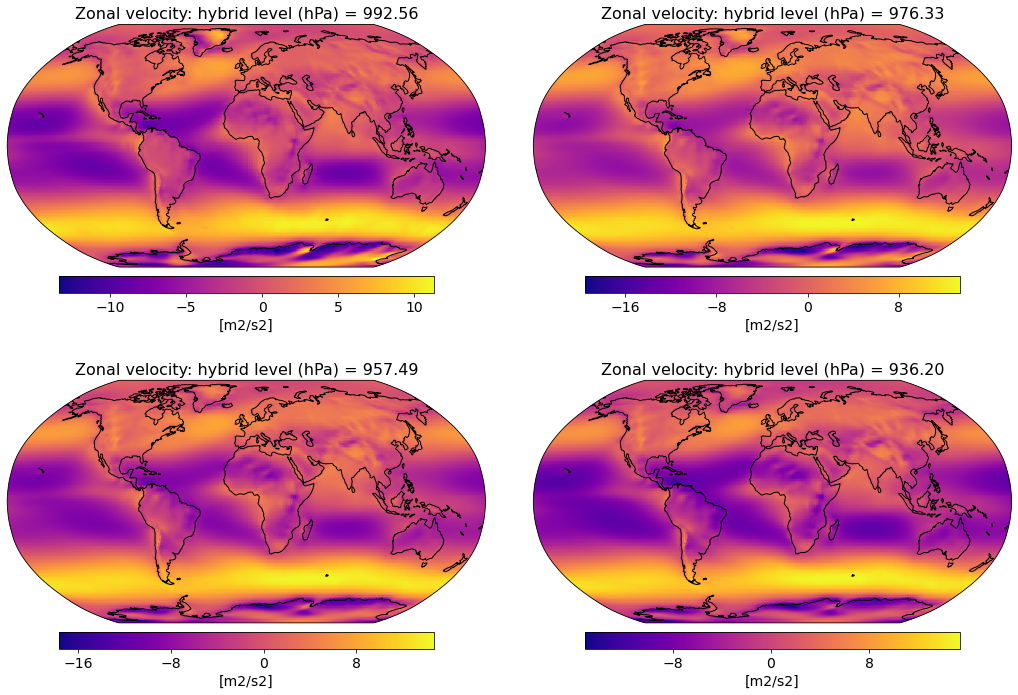

In [21]:
## --- Maps of UP2: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

for iLev in range(4):
    # Set global extent
    axs[iLev].set_global()
    
    # Make sure there's a cyclic point (otherwise you get a white line down the middle)
    U_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(U_timeMean[iLev,:,:]), dataDF.lon)
    
#     if iLev==0:
#         cMax = 1
#     else: 
#         cMax = 0.5
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iLev].pcolormesh(lon_cyclic,lat,U_cyclic,
#                                         vmin=0,
#                                         vmax=cMax,
                                        cmap='plasma',
                                        transform=ccrs.PlateCarree())
   
    # Add continent outlines 
    axs[iLev].coastlines()
    
    # Add colorbar 
    ax_position = axs[iLev].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    # Set plot title 
    axs[iLev].set_title('Zonal velocity: hybrid level (hPa) = %.2f' % lev_middle[iLev], fontsize=16)



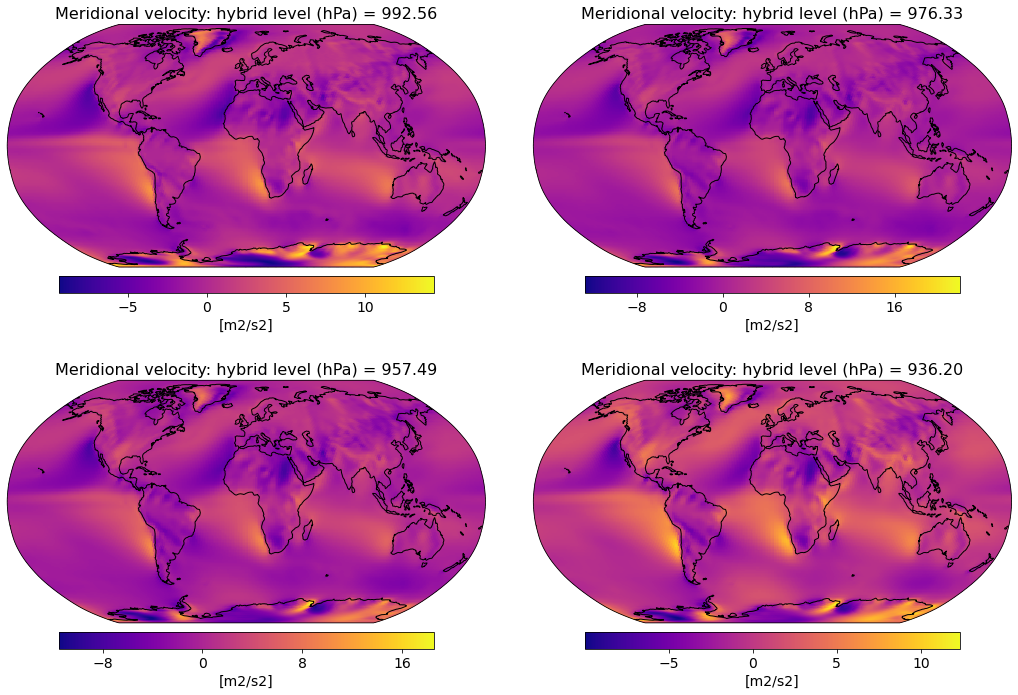

In [22]:
## --- Maps of UP2: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

for iLev in range(4):
    # Set global extent
    axs[iLev].set_global()
    
    # Make sure there's a cyclic point (otherwise you get a white line down the middle)
    V_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(V_timeMean[iLev,:,:]), dataDF.lon)
    
#     if iLev==0:
#         cMax = 1
#     else: 
#         cMax = 0.5
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iLev].pcolormesh(lon_cyclic,lat,V_cyclic,
#                                         vmin=0,
#                                         vmax=cMax,
                                        cmap='plasma',
                                        transform=ccrs.PlateCarree())
   
    # Add continent outlines 
    axs[iLev].coastlines()
    
    # Add colorbar 
    ax_position = axs[iLev].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    # Set plot title 
    axs[iLev].set_title('Meridional velocity: hybrid level (hPa) = %.2f' % lev_middle[iLev], fontsize=16)


## Global maps at lowest level U and second interface of UP2_CLUBB

In [26]:
# --- Get seasonal means --- #

iDJF = np.where((dates.month==1) | (dates.month<=3))[0]
iMAM = np.where((dates.month>=4) & (dates.month<=6))[0]
iJJA = np.where((dates.month>=7) & (dates.month<=9))[0]
iSON = np.where((dates.month>=10) & (dates.month<=12))[0]

# DJF 
UP2_DJFmean = np.squeeze(np.nanmean(UP2[iDJF,:,:,:], 0))
VP2_DJFmean = np.squeeze(np.nanmean(VP2[iDJF,:,:,:], 0))
WP2_DJFmean = np.squeeze(np.nanmean(WP2[iDJF,:,:,:], 0))
WP3_DJFmean = np.squeeze(np.nanmean(WP3[iDJF,:,:,:], 0))
U_DJFmean   = np.squeeze(np.nanmean(U[iDJF,:,:,:], 0))
V_DJFmean   = np.squeeze(np.nanmean(V[iDJF,:,:,:], 0))
print('Done with DJF means')

# MAM 
UP2_MAMmean = np.squeeze(np.nanmean(UP2[iMAM,:,:,:], 0))
VP2_MAMmean = np.squeeze(np.nanmean(VP2[iMAM,:,:,:], 0))
WP2_MAMmean = np.squeeze(np.nanmean(WP2[iMAM,:,:,:], 0))
WP3_MAMmean = np.squeeze(np.nanmean(WP3[iMAM,:,:,:], 0))
U_MAMmean   = np.squeeze(np.nanmean(U[iMAM,:,:,:], 0))
V_MAMmean   = np.squeeze(np.nanmean(V[iMAM,:,:,:], 0))
print('Done with MAM means')

# JJA
UP2_JJAmean = np.squeeze(np.nanmean(UP2[iJJA,:,:,:], 0))
VP2_JJAmean = np.squeeze(np.nanmean(VP2[iJJA,:,:,:], 0))
WP2_JJAmean = np.squeeze(np.nanmean(WP2[iJJA,:,:,:], 0))
WP3_JJAmean = np.squeeze(np.nanmean(WP3[iJJA,:,:,:], 0))
U_JJAmean   = np.squeeze(np.nanmean(U[iJJA,:,:,:], 0))
V_JJAmean   = np.squeeze(np.nanmean(V[iJJA,:,:,:], 0))
print('Done with JJA means')

# SON
UP2_SONmean = np.squeeze(np.nanmean(UP2[iSON,:,:,:], 0))
VP2_SONmean = np.squeeze(np.nanmean(VP2[iSON,:,:,:], 0))
WP2_SONmean = np.squeeze(np.nanmean(WP2[iSON,:,:,:], 0))
WP3_SONmean = np.squeeze(np.nanmean(WP3[iSON,:,:,:], 0))
U_SONmean   = np.squeeze(np.nanmean(U[iSON,:,:,:], 0))
V_SONmean   = np.squeeze(np.nanmean(V[iSON,:,:,:], 0))
print('Done with SON means')


Done with DJF means
Done with MAM means
Done with JJA means
Done with SON means


In [30]:
# Get cyclic point for all seasons in one array 
UP2_seasonal = np.full([4, len(lat), len(lon)+1], np.nan)
U_seasonal   = np.full([4, len(lat), len(lon)+1], np.nan)

UP2_seasonal[0,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_DJFmean[1,:,:]), dataDF.lon)
UP2_seasonal[1,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_MAMmean[1,:,:]), dataDF.lon)
UP2_seasonal[2,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_JJAmean[1,:,:]), dataDF.lon)
UP2_seasonal[3,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_SONmean[1,:,:]), dataDF.lon)

U_seasonal[0,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(U_DJFmean[1,:,:]), dataDF.lon)
U_seasonal[1,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(U_MAMmean[1,:,:]), dataDF.lon)
U_seasonal[2,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(U_JJAmean[1,:,:]), dataDF.lon)
U_seasonal[3,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(U_SONmean[1,:,:]), dataDF.lon)

# Array with season names 
seasonName = ['DJF','MAM','JJA','SON']


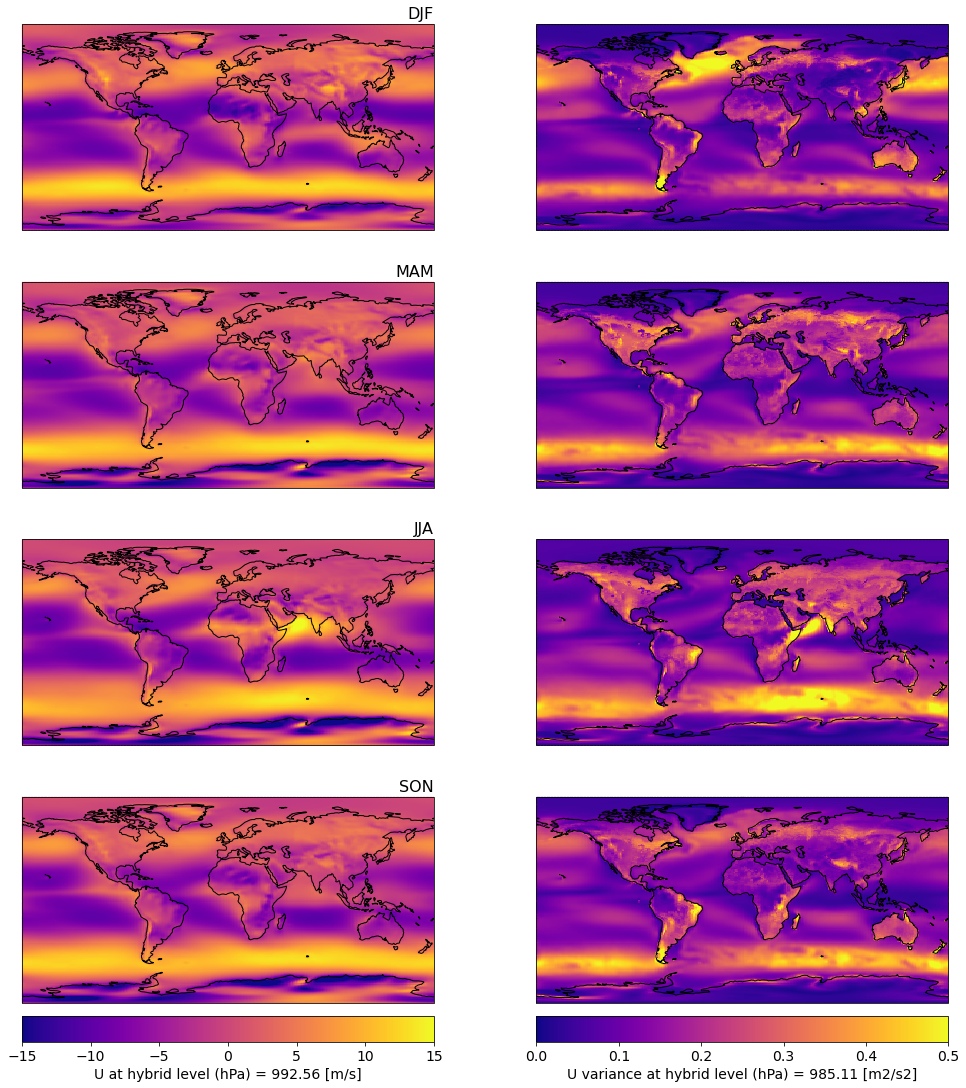

In [38]:
# Set up figure 
fig, axs = plt.subplots(4,2, figsize=(18, 18), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.25,wspace = 0.05)
#Put axs handles in array, axs 
axs = axs.ravel()

# Index used for plotting 
pltInd = 0 
for iSeason in range(4):
    # Set US extent
    #axs[pltInd].set_extent([220,300,20,60])
    axs[pltInd].set_global()
    axs[pltInd+1].set_global()
    
    # Contour U itself
    contour_plot = axs[pltInd].pcolormesh(lon_cyclic,lat,np.squeeze(U_seasonal[iSeason,:,:]),
                                        vmin=-15,
                                        vmax=15,
                                        cmap='plasma')
    # Add colorbars to bottom panels 
    if pltInd==6:
        # Handle colorbar for U 
        ax_position = axs[pltInd].get_position()
        cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
        cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
        # Control number of ticks via 'ticker' in matplotlib 
        tick_locator = ticker.MaxNLocator(nbins=7)
        cbar.locator = tick_locator
        cbar.update_ticks()
        # Set label and fontsize
        cbar.set_label('U at hybrid level (hPa) = %.2f [m/s]' % lev_middle[0],fontsize=14)
        cbar.ax.tick_params(labelsize=14)
    
    # Contour the variance of U
    contour_plot = axs[pltInd+1].pcolormesh(lon_cyclic,lat,np.squeeze(UP2_seasonal[iSeason,:,:]),
                                        vmin=0,
                                        vmax=0.5,
                                        cmap='plasma')
        # Add colorbars to bottom panels 
    if pltInd==6:
        # Handle colorbar for U variance 
        ax_position = axs[pltInd+1].get_position()
        cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
        cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
        # Control number of ticks via 'ticker' in matplotlib 
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        # Set label and fontsize
        cbar.set_label('U variance at hybrid level (hPa) = %.2f [m2/s2]' % lev_interface[1],fontsize=14)
        cbar.ax.tick_params(labelsize=14)
    
    # Add continent outlines 
    axs[pltInd].coastlines()
    axs[pltInd+1].coastlines()

    # Add some helpful labels 
    axs[pltInd].set_title(seasonName[iSeason], fontsize=16,loc='right')
    
    # Increment plot index by two to start on next row 
    pltInd = pltInd+2 


## Let's use the SREX regions as initial definitions

Useful example in documentation: https://regionmask.readthedocs.io/en/stable/notebooks/mask_3D.html



In [39]:
# Get basic info on SREX regions 
regionmask.defined_regions.srex

<regionmask.Regions>
Name:     SREX
Source:   Seneviratne et al., 2012 (https://www.ipcc.ch/site/assets/uploads/2...

Regions:
  1  ALA        Alaska/N.W. Canada
  2  CGI      Canada/Greenl./Icel.
  3  WNA          W. North America
  4  CNA          C. North America
  5  ENA          E. North America
..   ...                       ...
 22  EAS                   E. Asia
 23  SAS                   S. Asia
 24  SEA                 S.E. Asia
 25  NAU              N. Australia
 26  SAU  S. Australia/New Zealand

[26 regions]

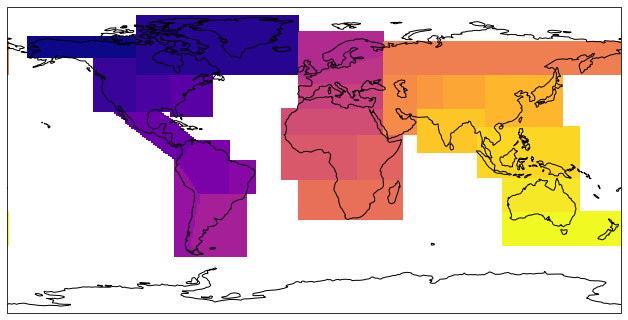

In [119]:
# Plot the mask we'll use 
f, ax = plt.subplots(figsize=(11, 8),subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()

mask2D = regionmask.defined_regions.srex.mask(lon, lat)
mask2D.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='plasma');


In [40]:
# Create 3D mask of the regions mapped out above 
#   (better for actually getting averages and masking out other regions)
RegMask = regionmask.defined_regions.srex.mask_3D(lon, lat)

Text(0.5, 1.0, 'Sahara')

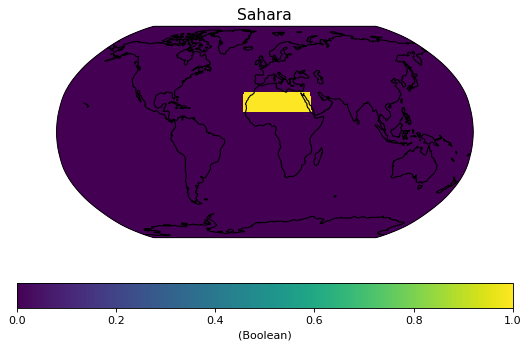

In [69]:
# Plot mask to make sure this is all right 
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Make plot
regSel = 14 -1
contour_plot = ax.pcolormesh(lon_cyclic,lat,RegMask[regSel,:,:],
                             transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='(Boolean)',orientation='horizontal')
ax.set_title(np.asarray(RegMask.names.values)[regSel], fontsize=14)

In [62]:

for iReg in range(26):
    print(iReg+1, RegMask.names.values[iReg])
    

1 Alaska/N.W. Canada
2 Canada/Greenl./Icel.
3 W. North America
4 C. North America
5 E. North America
6 Central America/Mexico
7 Amazon
8 N.E. Brazil
9 Coast South America
10 S.E. South America
11 N. Europe
12 C. Europe
13 S. Europe/Mediterranean
14 Sahara
15 W. Africa
16 E. Africa
17 S. Africa
18 N. Asia
19 W. Asia
20 C. Asia
21 Tibetan Plateau
22 E. Asia
23 S. Asia
24 S.E. Asia
25 N. Australia
26 S. Australia/New Zealand


In [41]:
# --- Get regional (weighted) averages of U and UP2 --- # 

# Define weights as cos of latitude 
weights = np.cos(np.deg2rad(lat))

U_regionalMean   = U[:,0,:,:].weighted(RegMask * weights).mean(dim=("lat", "lon"))
UP2_regionalMean = UP2[:,1,:,:].weighted(RegMask * weights).mean(dim=("lat", "lon"))


In [86]:
np.shape(U_regionalMean)

(768, 26)

### Scatter plot of regional mean U vs. variance of U

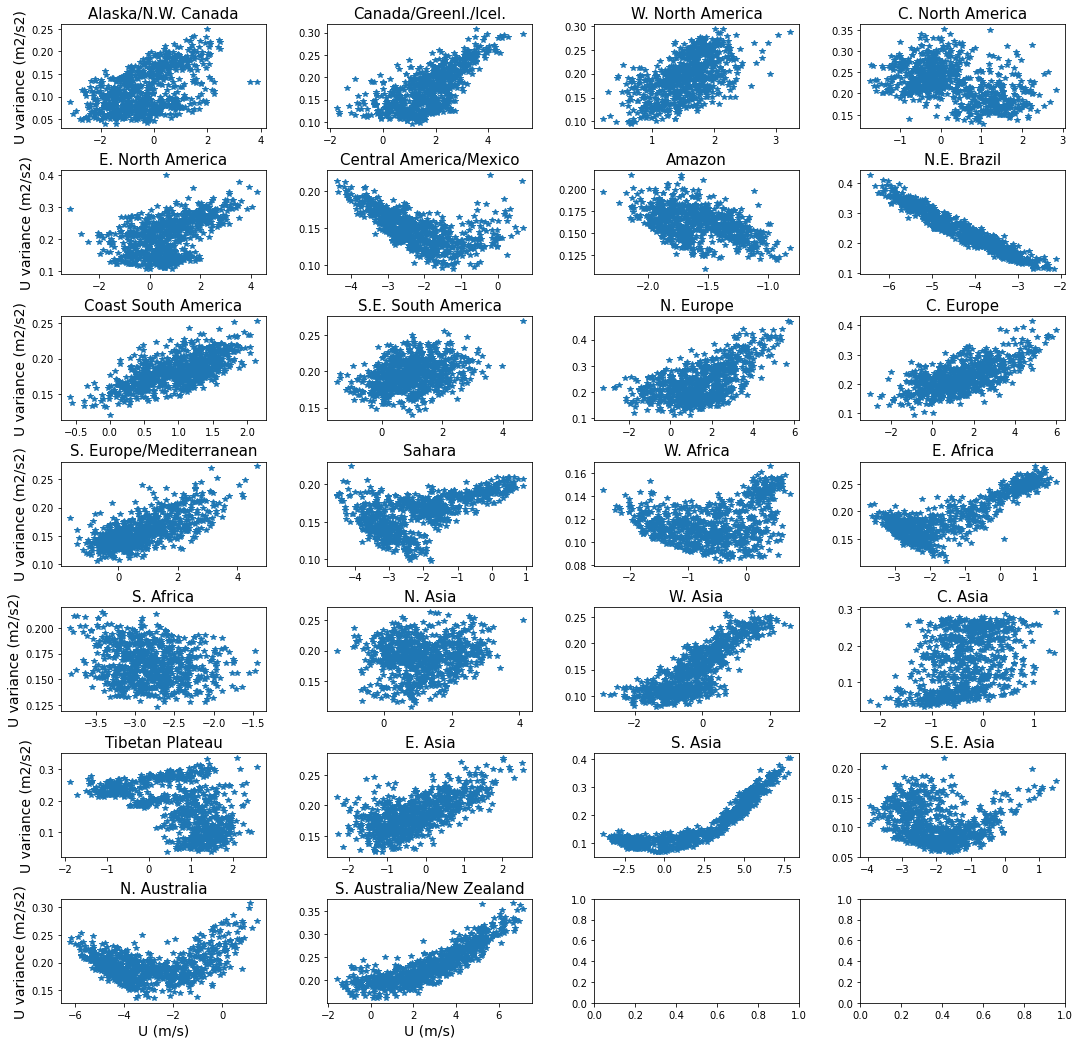

In [100]:
# Set up figure 
fig, axs = plt.subplots(7,4, figsize=(18, 18))
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
#Put axs handles in array, axs 
axs = axs.ravel()

for iReg in range(len(RegMask.names)):
    axs[iReg].plot(U_regionalMean[:,iReg],UP2_regionalMean[:,iReg],'*')
    
    axs[iReg].set_title(RegMask.names.values[iReg],fontsize=15)
    
    # Set axis labels only for outside plots 
    if iReg>=24:
        axs[iReg].set_xlabel('U (m/s)', fontsize=14)
    
    if ((iReg==0) | (iReg==4) | (iReg==8) | (iReg==12) | (iReg==16) | (iReg==20) | (iReg==24)):
        axs[iReg].set_ylabel('U variance (m2/s2)',fontsize=14)
        


**Maybe  color code seasonally?**

In [107]:
iDJF = np.where((dates.month==1) | (dates.month<=3))[0]
iMAM = np.where((dates.month>=4) & (dates.month<=6))[0]
iJJA = np.where((dates.month>=7) & (dates.month<=9))[0]
iSON = np.where((dates.month>=10) & (dates.month<=12))[0]


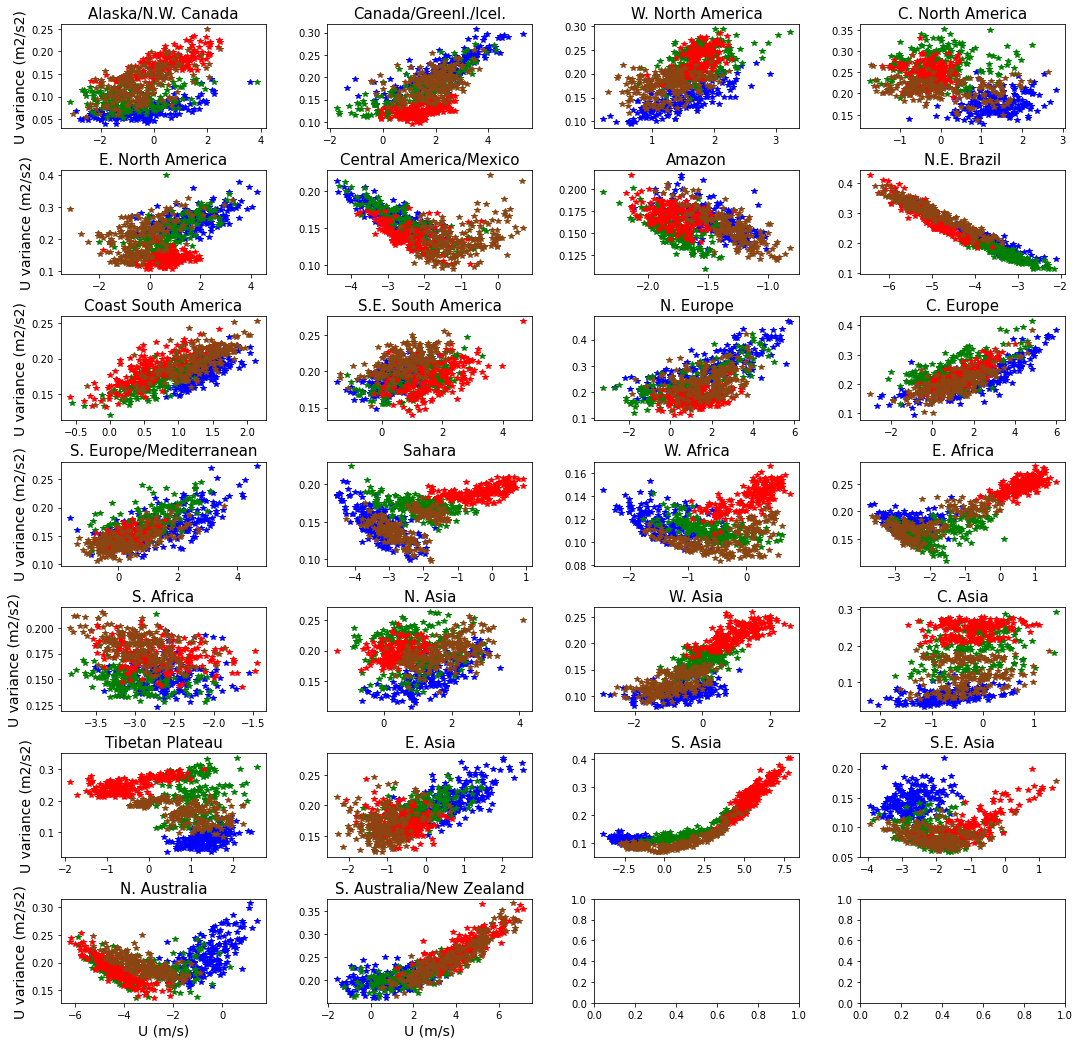

In [108]:
# Set up figure 
fig, axs = plt.subplots(7,4, figsize=(18, 18))
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
#Put axs handles in array, axs 
axs = axs.ravel()

for iReg in range(len(RegMask.names)):
    # Color code by region
    axs[iReg].plot(U_regionalMean[iDJF,iReg],UP2_regionalMean[iDJF,iReg],'b*')
    axs[iReg].plot(U_regionalMean[iMAM,iReg],UP2_regionalMean[iMAM,iReg],'g*')
    axs[iReg].plot(U_regionalMean[iJJA,iReg],UP2_regionalMean[iJJA,iReg],'r*')
    axs[iReg].plot(U_regionalMean[iSON,iReg],UP2_regionalMean[iSON,iReg],'*',color='saddlebrown')   
    
    # Set title
    axs[iReg].set_title(RegMask.names.values[iReg],fontsize=15)

    # If want easily comparable axes..
    #axs[iReg].set_ylim([0.03,0.45])
    
    # Set axis labels only for outside plots 
    if iReg>=24:
        axs[iReg].set_xlabel('U (m/s)', fontsize=14)
    
    if ((iReg==0) | (iReg==4) | (iReg==8) | (iReg==12) | (iReg==16) | (iReg==20) | (iReg==24)):
        axs[iReg].set_ylabel('U variance (m2/s2)',fontsize=14)
        



In [120]:
# Investigating option of a 2D histogram... 

# Let's say I just want U or UP2 by region...
r1 = RegMask.sel(region=4)

U_regSel   = U[:,0,:,:].where(r1)
UP2_regSel = UP2[:,1,:,:].where(r1)

# And then say I only want Jan...
iJan = np.where(dates.month==2)[0]
U_regSel_mon   = U_regSel[iJan,:,:].values
UP2_regSel_mon = UP2_regSel[iJan,:,:].values

# Flatten across space? 
U_regSel_mon_reshape = U_regSel_mon.reshape([len(iJan),len(lon)*len(lat)])


In [ ]:
# H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))

In [118]:
np.shape(U_regSel_mon)


(64, 192, 288)

In [121]:
np.shape(U_regSel_mon_reshape)

(64, 55296)

### Can we come up with some index to represent how poorly or well the mean wind works?

In [140]:
# Maybe look at std rather than variance? Same units that way. 
Ustd_regional = np.sqrt(UP2_regionalMean)

# Could look at std as fraction of wind speed 
STDfraction = Ustd_regional / np.abs(U_regionalMean)


In [160]:
# Take average over time 
avgFraction = np.nanmean(STDfraction,axis=0)
   
print('             Region             Ustd / np.abs(U) [time mean]')
print('         --------------       ------------------------------')
for iReg in range(len(RegMask.names)):
    print('%24s  %14.3f' % (RegMask.names.values[iReg], avgFraction[iReg]))


             Region             Ustd / np.abs(U) [time mean]
         --------------       ------------------------------
      Alaska/N.W. Canada           1.149
    Canada/Greenl./Icel.           0.758
        W. North America           0.312
        C. North America           5.048
        E. North America           3.312
  Central America/Mexico           0.606
                  Amazon           0.258
             N.E. Brazil           0.116
     Coast South America          13.950
      S.E. South America           1.729
               N. Europe           2.492
               C. Europe           1.607
 S. Europe/Mediterranean          22.399
                  Sahara           0.688
               W. Africa           2.635
               E. Africa           2.369
               S. Africa           0.148
                 N. Asia           2.240
                 W. Asia           2.165
                 C. Asia           3.433
         Tibetan Plateau           2.097
                 

In [164]:
np.shape(avgFraction[avgFraction>5])


(3,)

### Sanity check this works 

In [74]:
sel  = RegMask.sel(region=3)
selU = U[:,0,:,:].where(sel)


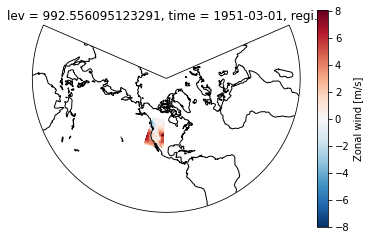

In [76]:
proj = ccrs.LambertConformal(central_longitude=-100)

ax = plt.subplot(111, projection=proj)

selU.isel(time=1).plot(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines();

## Try using mask of L-A coupling hotspots 

In [10]:
# Load mask from previous analysis
maskPath = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/couplingMask_SMvSHF.p'
couplingMask_SMvSHF = pickle.load( open( maskPath, "rb" ) )


In [11]:
# Make a mask for *other* regions 
maskOther = np.full([len(lat), len(lon)+1], np.nan) 

for iLat in range(len(lat)):
    for iLon in range(len(lon)+1):
        
        if np.isnan(couplingMask_SMvSHF[iLat,iLon]):
            maskOther[iLat,iLon] = 1

# Also limit to land points only 
landMask_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(landMask, lon)
maskOther = maskOther * landMask_cyclic


Text(0.5, 1.0, 'Coupling Hotspots (Sanity Check)')

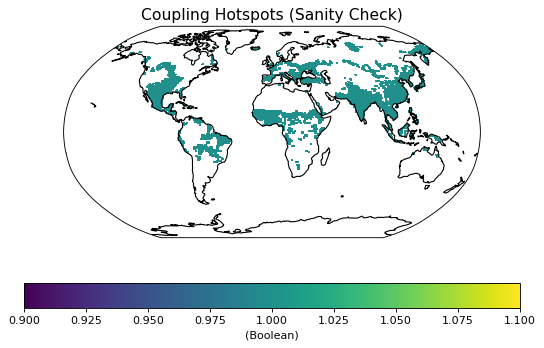

In [12]:
# Plot mask to make sure this is all right 
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,couplingMask_SMvSHF,
                             transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='(Boolean)',orientation='horizontal')
ax.set_title('Coupling Hotspots (Sanity Check)', fontsize=14)



Text(0.5, 1.0, 'All other gridcells (Sanity Check)')

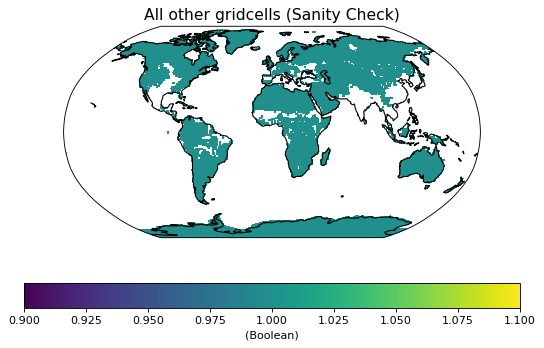

In [13]:
# Plot mask to make sure this is all right 
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,maskOther,
                             transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='(Boolean)',orientation='horizontal')
ax.set_title('All other gridcells (Sanity Check)', fontsize=14)


The masks seem to be right then; so let's look at some average fields in these hotspots vs. the rest of land area. 

In [13]:
# --- Mask out portions of U and UP2 based on hotspots --- #

nT = np.shape(U)[0]     # Number of days to worry about 

# Defint empty arrays for masked data
U_hotspot   = np.full([nT, len(lat), len(lon)+1], np.nan) 
UP2_hotspot = np.full([nT, len(lat), len(lon)+1], np.nan)  
U_other     = np.full([nT, len(lat), len(lon)+1], np.nan) 
UP2_other   = np.full([nT, len(lat), len(lon)+1], np.nan) 

# Get U and UP2 as cyclic (since mask is based on that)
U_cyclic, lon_cyclic   = cartopy.util.add_cyclic_point(U[:,0,:,:], lon)
UP2_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(UP2[:,1,:,:], lon)

# Mask out data by day
for iT in range(nT):
    # Mask out gridcells not in hotspots 
    U_hotspot[iT,:,:]   = U_cyclic[iT,:,:]    * couplingMask_SMvSHF
    UP2_hotspot[iT,:,:] = UP2_cyclic[iT,:,:]  * couplingMask_SMvSHF 
    
    # Also select gridcells outside of hotspots
    U_other[iT,:,:]     = U_cyclic[iT,:,:]   * maskOther
    UP2_other[iT,:,:]   = UP2_cyclic[iT,:,:] * maskOther

# Average in space over hotspots or other land gridcells 
U_hotspot_spaceMean   = np.squeeze(np.nanmean(np.nanmean(U_hotspot,axis=1),axis=1)) 
UP2_hotspot_spaceMean = np.squeeze(np.nanmean(np.nanmean(UP2_hotspot,axis=1),axis=1)) 
U_other_spaceMean     = np.squeeze(np.nanmean(np.nanmean(U_other,axis=1),axis=1)) 
UP2_other_spaceMean   = np.squeeze(np.nanmean(np.nanmean(UP2_other,axis=1),axis=1)) 

# What if we average in time instead? 
U_hotspot_timeMean   = np.squeeze(np.nanmean(U_hotspot,axis=0)) 
UP2_hotspot_timeMean = np.squeeze(np.nanmean(UP2_hotspot,axis=0))  
U_other_timeMean     = np.squeeze(np.nanmean(U_other,axis=0)) 
UP2_other_timeMean   = np.squeeze(np.nanmean(UP2_other,axis=0))  


<ipython-input-13-54247b2deaca>:26: RuntimeWarning: Mean of empty slice
  U_hotspot_spaceMean   = np.squeeze(np.nanmean(np.nanmean(U_hotspot,axis=1),axis=1))
<ipython-input-13-54247b2deaca>:27: RuntimeWarning: Mean of empty slice
  UP2_hotspot_spaceMean = np.squeeze(np.nanmean(np.nanmean(UP2_hotspot,axis=1),axis=1))
<ipython-input-13-54247b2deaca>:32: RuntimeWarning: Mean of empty slice
  U_hotspot_timeMean   = np.squeeze(np.nanmean(U_hotspot,axis=0))
<ipython-input-13-54247b2deaca>:33: RuntimeWarning: Mean of empty slice
  UP2_hotspot_timeMean = np.squeeze(np.nanmean(UP2_hotspot,axis=0))
<ipython-input-13-54247b2deaca>:34: RuntimeWarning: Mean of empty slice
  U_other_timeMean     = np.squeeze(np.nanmean(U_other,axis=0))
<ipython-input-13-54247b2deaca>:35: RuntimeWarning: Mean of empty slice
  UP2_other_timeMean   = np.squeeze(np.nanmean(UP2_other,axis=0))


Text(0, 0.5, 'U variance( m2/s2)')

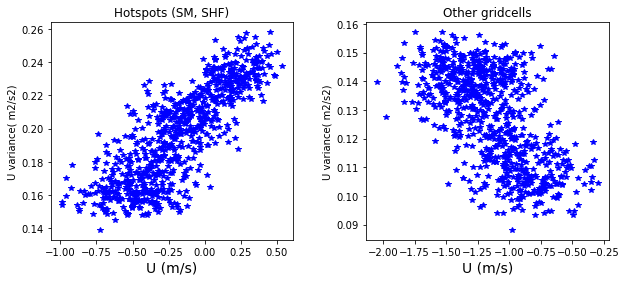

In [14]:
# Set up figure to show spatial means 
#   Each point is thus one month in the record 

fig, ax_array = plt.subplots(1,2, figsize=(10, 4))
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
ax1,ax2 = ax_array.flatten()

# Plot scatter of gridcells classified as hotspots 
ax1.plot(U_hotspot_spaceMean, UP2_hotspot_spaceMean,'b*')
ax1.set_title('Hotspots (SM, SHF)')
ax1.set_xlabel('U (m/s)', fontsize=14)
ax1.set_ylabel('U variance( m2/s2)')

# Plot scatter of other gridcells
ax2.plot(U_other_spaceMean, UP2_other_spaceMean,'b*')
ax2.set_title('Other gridcells')
ax2.set_xlabel('U (m/s)', fontsize=14)
ax2.set_ylabel('U variance( m2/s2)')


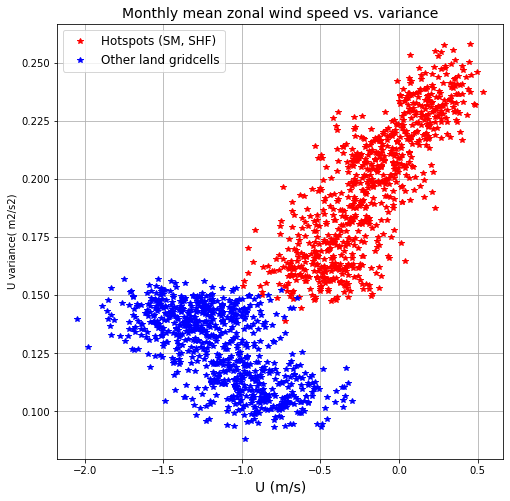

In [21]:
# Plot all in one?

fig, ax1 = plt.subplots(1,1, figsize=(8, 8))

# Plot scatter of gridcells classified as hotspots 
ax1.plot(U_hotspot_spaceMean, UP2_hotspot_spaceMean,'r*')
ax1.plot(U_other_spaceMean, UP2_other_spaceMean,'b*')
ax1.set_title('Monthly mean zonal wind speed vs. variance',fontsize=14)
ax1.set_xlabel('U (m/s)', fontsize=14)
ax1.set_ylabel('U variance( m2/s2)')
ax1.legend(['Hotspots (SM, SHF)', 'Other land gridcells'],fontsize=12)

ax1.grid()


In [22]:
# Maybe look at std rather than variance? Same units that way. 
Ustd_hotspot = np.sqrt(UP2_hotspot_spaceMean)
Ustd_other   = np.sqrt(UP2_other_spaceMean)

# Could look at std as fraction of wind speed 
STDfraction_hotspot = Ustd_hotspot / np.abs(U_hotspot_spaceMean)
STDfraction_other   = Ustd_other   / np.abs(U_other_spaceMean)

# Take average over time 
avgFraction_hotspot = np.nanmean(STDfraction_hotspot,axis=0)
avgFraction_other   = np.nanmean(STDfraction_other,axis=0)

print('Average std/abs(U) at hotspot gridcells:    %.5f' % avgFraction_hotspot)
print('Average std/abs(U) at other land gridcells: %.5f' % avgFraction_other)


Average std/abs(U) at hotspot gridcells:    6.32645
Average std/abs(U) at other land gridcells: 0.34007


**How different are things if average over time per gridcell first?**<br>
That is, do we want to keep each point as an individual gridcell, or do we care more about a region overall (reduces some of the variability if we average over that, but maybe not the clearest)

Text(0, 0.5, 'U variance( m2/s2)')

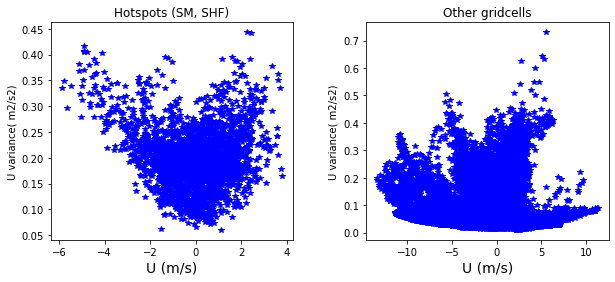

In [25]:
# Set up figure to show temporal means 
#   Each point is thus one gridcell's long-term mean

fig, ax_array = plt.subplots(1,2, figsize=(10, 4))
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
ax1,ax2 = ax_array.flatten()

# Plot scatter of gridcells classified as hotspots 
ax1.plot(U_hotspot_timeMean, UP2_hotspot_timeMean,'b*')
ax1.set_title('Hotspots (SM, SHF)')
ax1.set_xlabel('U (m/s)', fontsize=14)
ax1.set_ylabel('U variance( m2/s2)')

# Plot scatter of other gridcells
ax2.plot(U_other_timeMean, UP2_other_timeMean,'b*')
ax2.set_title('Other gridcells')
ax2.set_xlabel('U (m/s)', fontsize=14)
ax2.set_ylabel('U variance( m2/s2)')


In [30]:
np.shape(UP2_other_timeMean.reshape((len(lon)+1)*len(lat)))

(55488,)

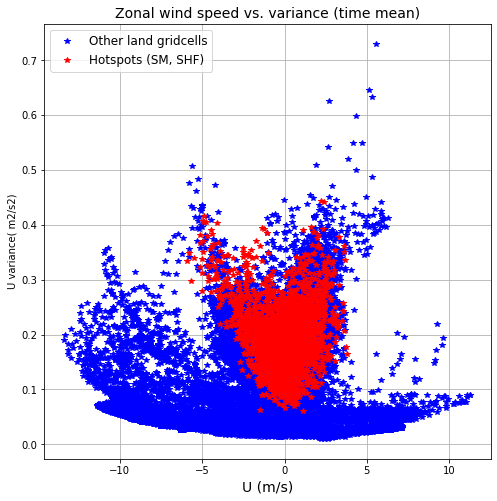

In [34]:
# Plot all in one?

fig, ax1 = plt.subplots(1,1, figsize=(8, 8))

# Plot scatter of gridcells classified as hotspots 
ax1.plot(U_other_timeMean.reshape((len(lon)+1)*len(lat)), UP2_other_timeMean.reshape((len(lon)+1)*len(lat)), 'b*')
ax1.plot(U_hotspot_timeMean.reshape((len(lon)+1)*len(lat)), UP2_hotspot_timeMean.reshape((len(lon)+1)*len(lat)),'r*')
ax1.legend(['Other land gridcells','Hotspots (SM, SHF)'],fontsize=12)
ax1.set_title('Zonal wind speed vs. variance (time mean)',fontsize=14)
ax1.set_xlabel('U (m/s)', fontsize=14)
ax1.set_ylabel('U variance( m2/s2)')

ax1.grid()



In [35]:
# Maybe look at std rather than variance? Same units that way. 
Ustd_hotspot = np.sqrt(UP2_hotspot_timeMean)
Ustd_other   = np.sqrt(UP2_other_timeMean)

# Could look at std as fraction of wind speed 
STDfraction_hotspot = Ustd_hotspot / np.abs(U_hotspot_timeMean)
STDfraction_other   = Ustd_other   / np.abs(U_other_timeMean)

# Take average over region 
avgFraction_hotspot = np.nanmean(np.nanmean(STDfraction_hotspot,axis=0),axis=0)
avgFraction_other   = np.nanmean(np.nanmean(STDfraction_other,axis=0),axis=0)

print('Average std/abs(U) at hotspot gridcells:    %.5f' % avgFraction_hotspot)
print('Average std/abs(U) at other land gridcells: %.5f' % avgFraction_other)


Average std/abs(U) at hotspot gridcells:    2.34955
Average std/abs(U) at other land gridcells: 0.99911


<ipython-input-35-d16935562cf4>:10: RuntimeWarning: Mean of empty slice
  avgFraction_hotspot = np.nanmean(np.nanmean(STDfraction_hotspot,axis=0),axis=0)


**Can we look at some kind of map?**<br>
Based on std/abs(U) by gridcell, maybe? Does this metric highlight hotspots as well? Or is it more topographically driven?

<i>Result:</i> This does seem to highlight the Gulf of Mexico coastal region ans particularly interesting, similar to the coupling hotspot there. But that's about it in terms of agreement. Other hotspots in this particular metric include along the Andes in South America, the Congo in Africa, much of the Maritime Continent, along the Himalayas.<br><br> 

In [70]:
# Select levels of interest for U and UP2
U_sel   = U[:,0,:,:]
UP2_sel = UP2[:,1,:,:]

# Get std rather than variance 
Ustd_sel = np.sqrt(UP2_sel)

# Look at fraction of Ustd vs. magnitude of wind speed
STDfraction_sel = Ustd_sel / np.abs(U_sel)

# Take average over time for each grid point 
avgFraction_sel = np.nanmean(STDfraction_sel, axis=0)


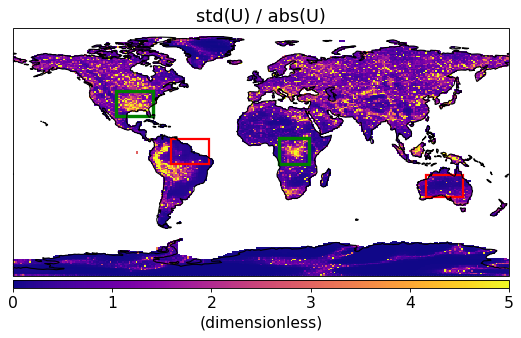

In [71]:
# Set up figure 
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax1.set_global()

# Make sure there's a cyclic point (otherwise you get a white line down the middle)
avgFraction_sel_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(avgFraction_sel, lon)

    
# Contour the (cyclic) field of interest 
contour_plot = ax1.pcolormesh(lon_cyclic,lat,avgFraction_sel_cyclic*landMask_cyclic,
                                    vmin=0,
                                    vmax=5,
                                    cmap='plasma')

# Add continent outlines 
ax1.coastlines()
    
# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
#     # Control number of ticks via 'ticker' in matplotlib 
#     tick_locator = ticker.MaxNLocator(nbins=5)
#     cbar.locator = tick_locator
#     cbar.update_ticks()
# Set label and fontsize
cbar.set_label('(dimensionless)',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Set plot title 
ax1.set_title('std(U) / abs(U)', fontsize=16)

# Define some interesting regions 
rect = patches.Rectangle((13,-9),22,19,linewidth=3,edgecolor='g',facecolor='none')    #Congo
ax1.add_patch(rect)

rect = patches.Rectangle((-105,26),27,18,linewidth=3,edgecolor='g',facecolor='none')  #Gulf coast
ax1.add_patch(rect)

# Pick out a few regions where it doesn't seem to be a big deal...
rect = patches.Rectangle((-65,-9),27,18,linewidth=2,edgecolor='r',facecolor='none')  #Amazon-ish
ax1.add_patch(rect)

rect = patches.Rectangle((120,-33),27,16,linewidth=2,edgecolor='r',facecolor='none')  #Australia
ax1.add_patch(rect)


**So what's going on in some of these places? Really interested in Congo and Gulf Coast right now...**

In [72]:
# Define box around the congo region (corresponds to rectangles above)
ilats_Gulf = np.where((lat>=26) & (lat<=26+18))[0]
ilons_Gulf = np.where((lon>=255) & (lon<=282))[0]

ilats_Congo = np.where((lat>=-9) & (lat<=-9+19))[0]
ilons_Congo = np.where((lon>=13) & (lon<=13+22))[0]

ilats_Amazon = np.where((lat>=-9) & (lat<=-9+18))[0]
ilons_Amazon = np.where((lon>=295) & (lon<=322))[0]

ilats_Australia = np.where((lat>=-33) & (lat<=-33+16))[0]
ilons_Australia = np.where((lon>=120) & (lon<=120+27))[0]


In [73]:
# Isolate regions in data 

U_Gulf    = U[:,0,ilats_Gulf,ilons_Gulf]   
UP2_Gulf  = UP2[:,1,ilats_Gulf,ilons_Gulf]

U_Congo   = U[:,0,ilats_Congo,ilons_Congo] 
UP2_Congo = UP2[:,1,ilats_Congo,ilons_Congo]

U_Amazon   = U[:,0,ilats_Amazon,ilons_Amazon]
UP2_Amazon = UP2[:,1,ilats_Amazon,ilons_Amazon]

U_Australia   = U[:,0,ilats_Australia,ilons_Australia]
UP2_Australia = UP2[:,1,ilats_Australia,ilons_Australia]


In [74]:
# For gulf coast and amazon regions, mask out ocean values? 
#    Had some really weird issues masking, so this looks ridiculous

for iT in range(nT):
    U_Gulf[iT,:,:]   = U_Gulf[iT,:,:] * landMask[min(ilats_Gulf):max(ilats_Gulf)+1,min(ilons_Gulf):max(ilons_Gulf)+1]
    UP2_Gulf[iT,:,:] = UP2_Gulf[iT,:,:] * landMask[min(ilats_Gulf):max(ilats_Gulf)+1,min(ilons_Gulf):max(ilons_Gulf)+1]

    U_Amazon[iT,:,:]   = U_Amazon[iT,:,:] * landMask[min(ilats_Amazon):max(ilats_Amazon)+1,min(ilons_Amazon):max(ilons_Amazon)+1]
    UP2_Amazon[iT,:,:] = UP2_Amazon[iT,:,:] * landMask[min(ilats_Amazon):max(ilats_Amazon)+1,min(ilons_Amazon):max(ilons_Amazon)+1]
    
    U_Australia[iT,:,:]   = U_Australia[iT,:,:] * landMask[min(ilats_Australia):max(ilats_Australia)+1,min(ilons_Australia):max(ilons_Australia)+1]
    UP2_Australia[iT,:,:] = UP2_Australia[iT,:,:] * landMask[min(ilats_Australia):max(ilats_Australia)+1,min(ilons_Australia):max(ilons_Australia)+1]
    

<ipython-input-41-8dd57255ece4>:7: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon[ilons_Gulf],lat[ilats_Gulf],np.squeeze(np.nanmean(U_Gulf,axis=0)),
<ipython-input-41-8dd57255ece4>:19: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon[ilons_Amazon],lat[ilats_Amazon],np.squeeze(np.nanmean(U_Amazon,axis=0)),
<ipython-input-41-8dd57255ece4>:25: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon[ilons_Australia],lat[ilats_Australia],np.squeeze(np.nanmean(U_Australia,axis=0)),


Text(0.5, 1.0, 'Regional selection of U (Sanity Check)')

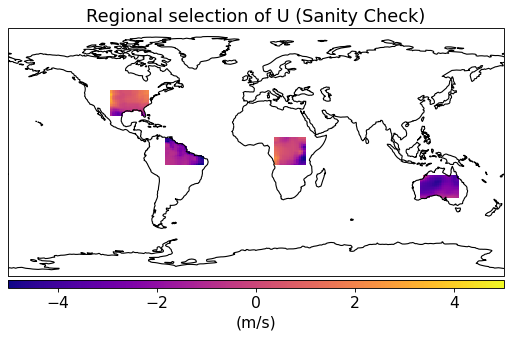

In [41]:
# Set up figure 
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax1.set_global()
    
# Contour the (cyclic) field of interest 
contour_plot = ax1.pcolormesh(lon[ilons_Gulf],lat[ilats_Gulf],np.squeeze(np.nanmean(U_Gulf,axis=0)),
                                    vmin=-5,
                                    vmax=5,
                                    cmap='plasma')

# Contour the (cyclic) field of interest 
contour_plot = ax1.pcolormesh(lon[ilons_Congo],lat[ilats_Congo],np.squeeze(np.nanmean(U_Congo,axis=0)),
                                    vmin=-5,
                                    vmax=5,
                                    cmap='plasma')

# Contour the (cyclic) field of interest 
contour_plot = ax1.pcolormesh(lon[ilons_Amazon],lat[ilats_Amazon],np.squeeze(np.nanmean(U_Amazon,axis=0)),
                                    vmin=-5,
                                    vmax=5,
                                    cmap='plasma')

# Contour the (cyclic) field of interest 
contour_plot = ax1.pcolormesh(lon[ilons_Australia],lat[ilats_Australia],np.squeeze(np.nanmean(U_Australia,axis=0)),
                                    vmin=-5,
                                    vmax=5,
                                    cmap='plasma')

# Add continent outlines 
ax1.coastlines()
    
# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
#     # Control number of ticks via 'ticker' in matplotlib 
#     tick_locator = ticker.MaxNLocator(nbins=5)
#     cbar.locator = tick_locator
#     cbar.update_ticks()
# Set label and fontsize
cbar.set_label('(m/s)',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Set plot title 
ax1.set_title('Regional selection of U (Sanity Check)', fontsize=16)


In [75]:
# Average over those regions to get a single time series at each
Umean_Gulf    = np.nanmean(np.nanmean(U_Gulf,axis=1),axis=1)  
UP2mean_Gulf  = np.nanmean(np.nanmean(UP2_Gulf,axis=1),axis=1)  

Umean_Congo   = np.nanmean(np.nanmean(U_Congo,axis=1),axis=1)  
UP2mean_Congo = np.nanmean(np.nanmean(UP2_Congo,axis=1),axis=1)  

Umean_Amazon   = np.nanmean(np.nanmean(U_Amazon,axis=1),axis=1)  
UP2mean_Amazon = np.nanmean(np.nanmean(UP2_Amazon,axis=1),axis=1)  

Umean_Australia   = np.nanmean(np.nanmean(U_Australia,axis=1),axis=1)  
UP2mean_Australia = np.nanmean(np.nanmean(UP2_Australia,axis=1),axis=1)  


In [70]:
# # Lets do error bars as 1 std  
# U_Gulf_1std   = np.nanstd(U_Gulf.values.reshape([nT,   len(ilons_Gulf)*len(ilats_Gulf)]),axis=1)
# UP2_Gulf_1std = np.nanstd(UP2_Gulf.values.reshape([nT, len(ilons_Gulf)*len(ilats_Gulf)]),axis=1)

# U_Congo_1std   = np.nanstd(U_Congo.values.reshape([nT,   len(ilons_Congo)*len(ilats_Congo)]),axis=1)
# UP2_Congo_1std = np.nanstd(UP2_Congo.values.reshape([nT, len(ilons_Congo)*len(ilats_Congo)]),axis=1)

# U_Amazon_1std   = np.nanstd(U_Amazon.values.reshape([nT,   len(ilons_Amazon)*len(ilats_Amazon)]),axis=1)
# UP2_Amazon_1std = np.nanstd(UP2_Amazon.values.reshape([nT, len(ilons_Amazon)*len(ilats_Amazon)]),axis=1)

# U_Australia_1std   = np.nanstd(U_Australia.values.reshape([nT,   len(ilons_Australia)*len(ilats_Australia)]),axis=1)
# UP2_Australia_1std = np.nanstd(UP2_Australia.values.reshape([nT, len(ilons_Australia)*len(ilats_Australia)]),axis=1)


(-5479.0, -1826.0)

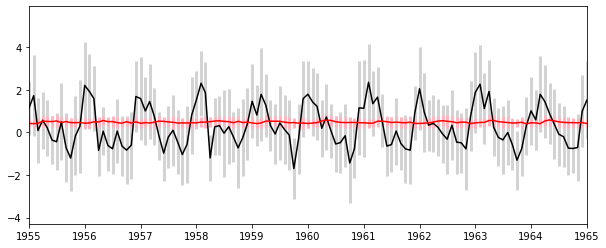

In [76]:
# # Plot timeseries of U and UP2 in each region 

# fig, ax1 = plt.subplots(1,1, figsize=(10, 4))

# # Plot time series for Gulf of Mexico region
# ax1.errorbar(dates, Umean_Gulf,yerr=U_Gulf_1std,fmt='k-',ecolor='lightgray',elinewidth=3,capsize=0)
# ax1.errorbar(dates, np.sqrt(UP2mean_Gulf),yerr=np.sqrt(UP2_Gulf_1std),fmt='r-',ecolor='lightpink',elinewidth=3,capsize=0)
# # ax1.plot(dates,-np.sqrt(UP2mean_Gulf), 'r--')
# # ax1.set_ylabel('(m/s)')
# ax1.set_xlim([datetime.date(1955,1,1), datetime.date(1965,1,1)])
# # ax1.set_title('Gulf Coast', fontsize=14)
# # ax1.legend(['U','sqrt(UP2_CLUBB)'])




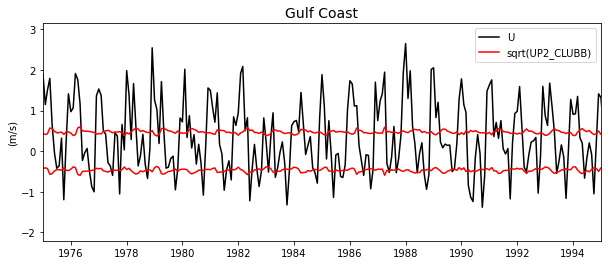

In [78]:
# Plot timeseries of U and UP2 in each region 

fig, ax1 = plt.subplots(1,1, figsize=(10, 4))

# Plot time series for Gulf of Mexico region
ax1.plot(dates, Umean_Gulf,'k-')
ax1.plot(dates, np.sqrt(UP2mean_Gulf),'r-')
ax1.plot(dates,-np.sqrt(UP2mean_Gulf), 'r-')
ax1.set_ylabel('(m/s)')
ax1.set_xlim([datetime.date(1975,1,1), datetime.date(1995,1,1)])
ax1.set_title('Gulf Coast', fontsize=14)
ax1.legend(['U','sqrt(UP2_CLUBB)'])

# ax2 = ax1.twinx()
# ax2.plot(dates,UP2mean_Gulf,'r-')
# ax2.set_ylabel('Zonal Velocity Variance (m2/s2)')


Text(0, 0.5, 'Zonal Velocity Variance (m2/s2)')

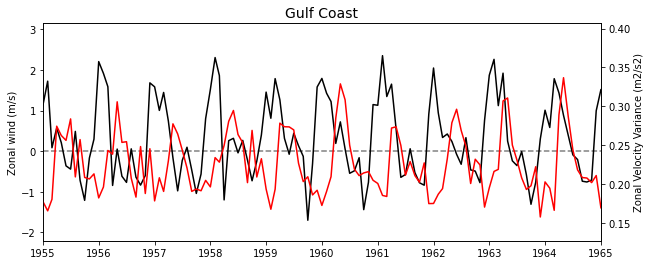

In [252]:
# Plot timeseries of U and UP2 in each region 

fig, ax1 = plt.subplots(1,1, figsize=(10, 4))

# Plot time series for Gulf of Mexico region
ax1.axhline(0,color='gray',linestyle='--')
ax1.plot(dates, Umean_Gulf,'k-')
#ax1.plot(dates, UP2mean_Gulf,'r-')
ax1.set_ylabel('Zonal wind (m/s)')
ax1.set_xlim([datetime.date(1955,1,1), datetime.date(1965,1,1)])
ax1.set_title('Gulf Coast', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(dates,UP2mean_Gulf,'r-')
ax2.set_ylabel('Zonal Velocity Variance (m2/s2)')


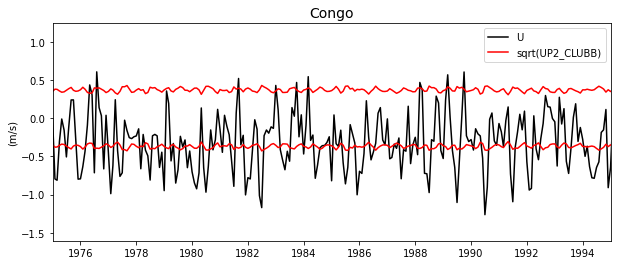

In [79]:
# Plot timeseries of U and UP2 in each region 

fig, ax1 = plt.subplots(1,1, figsize=(10, 4))

# Plot time series for Congo region
ax1.plot(dates, Umean_Congo,'k-')
ax1.plot(dates, np.sqrt(UP2mean_Congo),'r-')
ax1.plot(dates,-np.sqrt(UP2mean_Congo), 'r-')
ax1.set_ylabel('(m/s)')
ax1.set_xlim([datetime.date(1975,1,1), datetime.date(1995,1,1)])
ax1.set_title('Congo', fontsize=14)
ax1.legend(['U','sqrt(UP2_CLUBB)'])

# ax2 = ax1.twinx()
# ax2.plot(dates,UP2mean_Gulf,'r-')
# ax2.set_ylabel('Zonal Velocity Variance (m2/s2)')




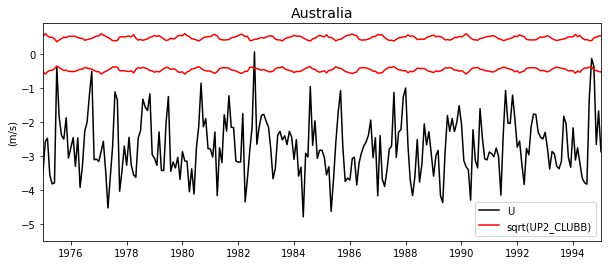

In [80]:
# Plot timeseries of U and UP2 in each region 

fig, ax1 = plt.subplots(1,1, figsize=(10, 4))

# Plot time series for Congo region
ax1.plot(dates, Umean_Australia,'k-')
ax1.plot(dates, np.sqrt(UP2mean_Australia),'r-')
ax1.plot(dates,-np.sqrt(UP2mean_Australia), 'r-')
ax1.set_ylabel('(m/s)')
ax1.set_xlim([datetime.date(1975,1,1), datetime.date(1995,1,1)])
ax1.set_title('Australia', fontsize=14)
ax1.legend(['U','sqrt(UP2_CLUBB)'])



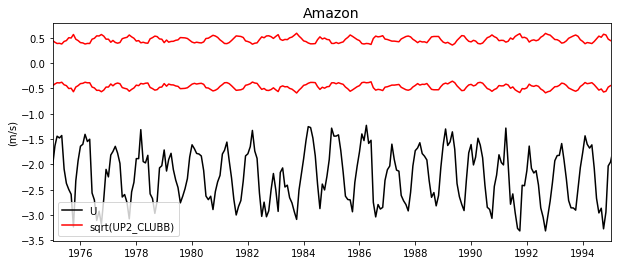

In [81]:
# Plot timeseries of U and UP2 in each region 

fig, ax1 = plt.subplots(1,1, figsize=(10, 4))

# Plot time series for Congo region
ax1.plot(dates, Umean_Amazon,'k-')
ax1.plot(dates, np.sqrt(UP2mean_Amazon),'r-')
ax1.plot(dates,-np.sqrt(UP2mean_Amazon), 'r-')
ax1.set_ylabel('(m/s)')
ax1.set_xlim([datetime.date(1975,1,1), datetime.date(1995,1,1)])
ax1.set_title('Amazon', fontsize=14)
ax1.legend(['U','sqrt(UP2_CLUBB)'])




**What would the average annual cycle look like for both of these?**

In [83]:
# Set up empty arrays
Umonthly_Gulf        = np.full([12],np.nan)
UP2monthly_Gulf      = np.full([12],np.nan)
Umonthly_Congo       = np.full([12],np.nan)
UP2monthly_Congo     = np.full([12],np.nan)
Umonthly_Amazon      = np.full([12],np.nan)
UP2monthly_Amazon    = np.full([12],np.nan)
Umonthly_Australia   = np.full([12],np.nan)
UP2monthly_Australia = np.full([12],np.nan)

Umonthly_Gulf_std        = np.full([12],np.nan)
UP2monthly_Gulf_std      = np.full([12],np.nan)
Umonthly_Congo_std       = np.full([12],np.nan)
UP2monthly_Congo_std     = np.full([12],np.nan)
Umonthly_Amazon_std      = np.full([12],np.nan)
UP2monthly_Amazon_std    = np.full([12],np.nan)
Umonthly_Australia_std   = np.full([12],np.nan)
UP2monthly_Australia_std = np.full([12],np.nan)

# Get average values for each month 
for iMon in range(11): 
    iLoc = np.where(dates.month==iMon+2)
        
    # Get mean of month
    Umonthly_Gulf[iMon]    = np.nanmean(Umean_Gulf[iLoc])
    UP2monthly_Gulf[iMon]  = np.nanmean(UP2mean_Gulf[iLoc])
    Umonthly_Gulf_std[iMon]    = np.nanstd(Umean_Gulf[iLoc])
    UP2monthly_Gulf_std[iMon]  = np.nanstd(UP2mean_Gulf[iLoc])
    
    Umonthly_Congo[iMon]   = np.nanmean(Umean_Congo[iLoc])
    UP2monthly_Congo[iMon] = np.nanmean(UP2mean_Congo[iLoc])
    Umonthly_Congo_std[iMon]   = np.nanstd(Umean_Congo[iLoc])
    UP2monthly_Congo_std[iMon] = np.nanstd(UP2mean_Congo[iLoc])
    
    Umonthly_Amazon[iMon]   = np.nanmean(Umean_Amazon[iLoc])
    UP2monthly_Amazon[iMon] = np.nanmean(UP2mean_Amazon[iLoc])
    Umonthly_Amazon_std[iMon]   = np.nanstd(Umean_Amazon[iLoc])
    UP2monthly_Amazon_std[iMon] = np.nanstd(UP2mean_Amazon[iLoc])
    
    Umonthly_Australia[iMon]   = np.nanmean(Umean_Australia[iLoc])
    UP2monthly_Australia[iMon] = np.nanmean(UP2mean_Australia[iLoc])
    Umonthly_Australia_std[iMon]   = np.nanstd(Umean_Australia[iLoc])
    UP2monthly_Australia_std[iMon] = np.nanstd(UP2mean_Australia[iLoc])
        
        
# Handle December separately
iDec = np.where(dates.month==1)
Umonthly_Gulf[-1]    = np.nanmean(Umean_Gulf[iDec])
UP2monthly_Gulf[-1]  = np.nanmean(UP2mean_Gulf[iDec])
Umonthly_Gulf_std[-1]    = np.nanstd(Umean_Gulf[iDec])
UP2monthly_Gulf_std[-1]  = np.nanstd(UP2mean_Gulf[iDec])

Umonthly_Congo[-1]   = np.nanmean(Umean_Congo[iDec])
UP2monthly_Congo[-1] = np.nanmean(UP2mean_Congo[iDec])
Umonthly_Congo_std[-1]   = np.nanstd(Umean_Congo[iDec])
UP2monthly_Congo_std[-1] = np.nanstd(UP2mean_Congo[iDec])

Umonthly_Amazon[-1]   = np.nanmean(Umean_Amazon[iDec])
UP2monthly_Amazon[-1] = np.nanmean(UP2mean_Amazon[iDec])
Umonthly_Amazon_std[-1]   = np.nanstd(Umean_Amazon[iDec])
UP2monthly_Amazon_std[-1] = np.nanstd(UP2mean_Amazon[iDec])

Umonthly_Australia[-1]   = np.nanmean(Umean_Australia[iDec])
UP2monthly_Australia[-1] = np.nanmean(UP2mean_Australia[iDec])
Umonthly_Australia_std[-1]   = np.nanstd(Umean_Australia[iDec])
UP2monthly_Australia_std[-1] = np.nanstd(UP2mean_Australia[iDec])


(0.5, 12.5)

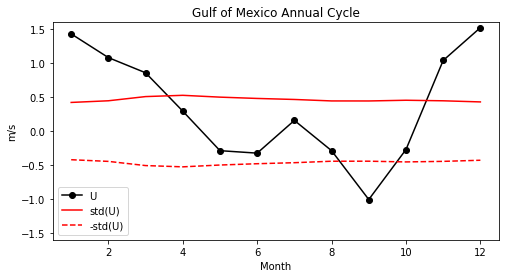

In [228]:
# fig, ax1 = plt.subplots(1,1, figsize=(8, 4))

# ax1.plot(np.arange(12)+1, Umonthly_Gulf,'o-',color='k')
# ax1.plot(np.arange(12)+1, np.sqrt(UP2monthly_Gulf),'r-')
# ax1.plot(np.arange(12)+1, -np.sqrt(UP2monthly_Gulf),'r--')

# ax1.set_title('Gulf of Mexico Annual Cycle')
# ax1.set_xlabel('Month')
# ax1.set_ylabel('m/s')
# ax1.legend(['U','std(U)','-std(U)'])
# ax1.set_ylim([-1.6, 1.6])
# ax1.set_xlim([0.5, 12.5])


(0.5, 12.5)

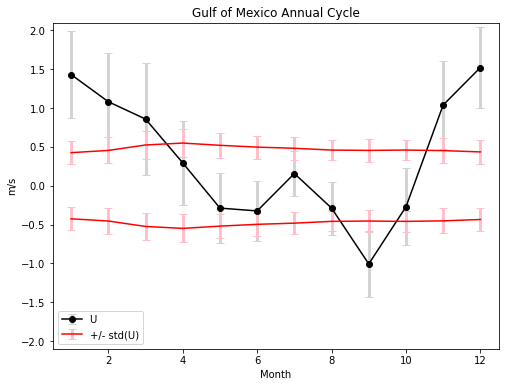

In [84]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.errorbar(np.arange(12)+1, Umonthly_Gulf,yerr=Umonthly_Gulf_std,fmt='ko-',ecolor='lightgray',elinewidth=3,capsize=4)
ax1.errorbar(np.arange(12)+1, np.sqrt(UP2monthly_Gulf), yerr=np.sqrt(UP2monthly_Gulf_std), fmt='r-',ecolor='pink',elinewidth=3,capsize=4)
ax1.errorbar(np.arange(12)+1, -np.sqrt(UP2monthly_Gulf), yerr=np.sqrt(UP2monthly_Gulf_std), fmt='r-',ecolor='pink',elinewidth=3,capsize=4)

ax1.set_title('Gulf of Mexico Annual Cycle')
ax1.set_xlabel('Month')
ax1.set_ylabel('m/s')
ax1.legend(['U','+/- std(U)'])
ax1.set_ylim([-2.1, 2.1])
ax1.set_xlim([0.5, 12.5])


(0.5, 12.5)

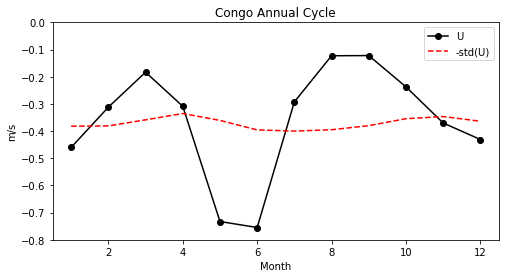

In [229]:
# fig, ax1 = plt.subplots(1,1, figsize=(8, 4))

# ax1.plot(np.arange(12)+1, Umonthly_Congo,'o-',color='k')
# ax1.plot(np.arange(12)+1, -np.sqrt(UP2monthly_Congo),'r--')

# ax1.set_title('Congo Annual Cycle')
# ax1.set_xlabel('Month')
# ax1.set_ylabel('m/s')
# ax1.legend(['U','-std(U)'])
# ax1.set_ylim([-0.8,0])
# ax1.set_xlim([0.5, 12.5])



(0.5, 12.5)

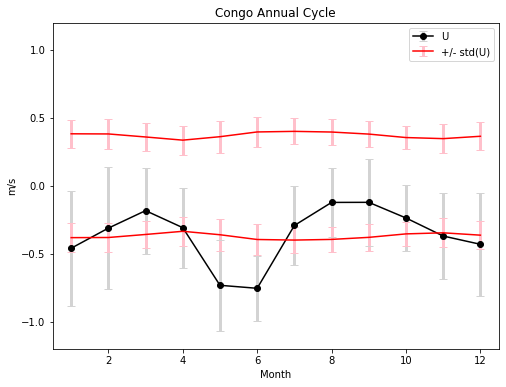

In [85]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.errorbar(np.arange(12)+1, Umonthly_Congo,yerr=Umonthly_Congo_std,fmt='ko-',ecolor='lightgray',elinewidth=3,capsize=4)
ax1.errorbar(np.arange(12)+1, np.sqrt(UP2monthly_Congo), yerr=np.sqrt(UP2monthly_Congo_std), fmt='r-',ecolor='pink',elinewidth=3,capsize=4)
ax1.errorbar(np.arange(12)+1, -np.sqrt(UP2monthly_Congo), yerr=np.sqrt(UP2monthly_Congo_std), fmt='r-',ecolor='pink',elinewidth=3,capsize=4)

ax1.set_title('Congo Annual Cycle')
ax1.set_xlabel('Month')
ax1.set_ylabel('m/s')
ax1.legend(['U','+/- std(U)'])
ax1.set_ylim([-1.2,1.2])
ax1.set_xlim([0.5, 12.5])



<br>
For comparison, what would the annual cycle of U and UP2 (using a sqrt of that) look like for a region that does *not* show an impact of variance? That is, does this metric actually pick out regions where the mean can be hugely impacted by the variance? <br><br>

(0.5, 12.5)

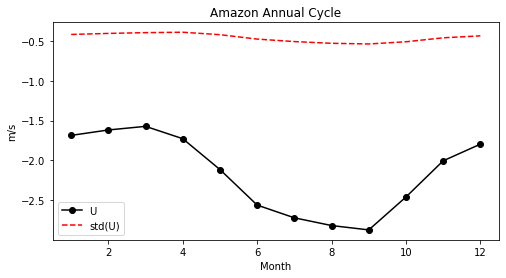

In [277]:
# fig, ax1 = plt.subplots(1,1, figsize=(8, 4))

# ax1.plot(np.arange(12)+1, Umonthly_Amazon,'o-',color='k')
# ax1.plot(np.arange(12)+1, -np.sqrt(UP2monthly_Amazon),'r--')

# ax1.set_title('Amazon Annual Cycle')
# ax1.set_xlabel('Month')
# ax1.set_ylabel('m/s')
# ax1.legend(['U','std(U)','-std(U)'])
# #ax1.set_ylim([-1.6, 1.6])
# ax1.set_xlim([0.5, 12.5])



(0.5, 12.5)

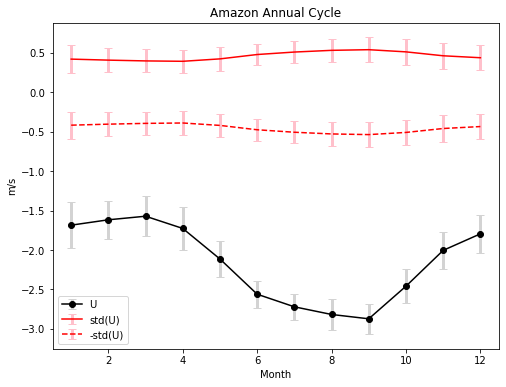

In [104]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.errorbar(np.arange(12)+1, Umonthly_Amazon,yerr=Umonthly_Amazon_std,fmt='ko-',ecolor='lightgray',elinewidth=3,capsize=4)
ax1.errorbar(np.arange(12)+1, np.sqrt(UP2monthly_Amazon), yerr=np.sqrt(UP2monthly_Amazon_std), fmt='r-',ecolor='pink',elinewidth=3,capsize=4)
ax1.errorbar(np.arange(12)+1, -np.sqrt(UP2monthly_Amazon), yerr=np.sqrt(UP2monthly_Amazon_std), fmt='r--',ecolor='pink',elinewidth=3,capsize=4)

ax1.set_title('Amazon Annual Cycle')
ax1.set_xlabel('Month')
ax1.set_ylabel('m/s')
ax1.legend(['U','std(U)','-std(U)'])
#ax1.set_ylim([-1.6, 1.6])
ax1.set_xlim([0.5, 12.5])



(0.5, 12.5)

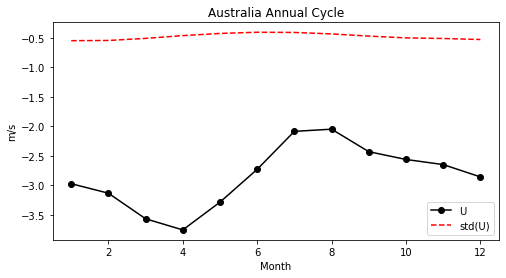

In [278]:
# fig, ax1 = plt.subplots(1,1, figsize=(8, 4))

# ax1.plot(np.arange(12)+1, Umonthly_Australia,'o-',color='k')
# ax1.plot(np.arange(12)+1, -np.sqrt(UP2monthly_Australia),'r--')

# ax1.set_title('Australia Annual Cycle')
# ax1.set_xlabel('Month')
# ax1.set_ylabel('m/s')
# ax1.legend(['U','std(U)','-std(U)'])
# #ax1.set_ylim([-1.6, 1.6])
# ax1.set_xlim([0.5, 12.5])




(0.5, 12.5)

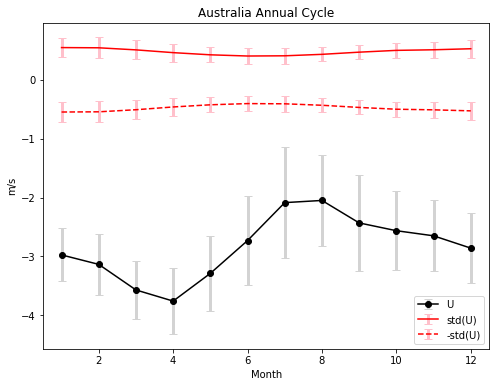

In [105]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.errorbar(np.arange(12)+1, Umonthly_Australia,yerr=Umonthly_Australia_std,fmt='ko-',ecolor='lightgray',elinewidth=3,capsize=4)
ax1.errorbar(np.arange(12)+1, np.sqrt(UP2monthly_Australia), yerr=np.sqrt(UP2monthly_Australia_std), fmt='r-',ecolor='pink',elinewidth=3,capsize=4)
ax1.errorbar(np.arange(12)+1, -np.sqrt(UP2monthly_Australia), yerr=np.sqrt(UP2monthly_Australia_std), fmt='r--',ecolor='pink',elinewidth=3,capsize=4)

ax1.set_title('Australia Annual Cycle')
ax1.set_xlabel('Month')
ax1.set_ylabel('m/s')
ax1.legend(['U','std(U)','-std(U)'])
#ax1.set_ylim([-1.6, 1.6])
ax1.set_xlim([0.5, 12.5])



## Is there any sensitivity of zonal relationship to lev/ilev chosen? (reasonably speaking)

In [34]:
print(lev_middle)
print(lev_interface)

[992.55609512 976.32540739 957.48547954 936.19839847 912.64454694
 887.02024892 859.53476653 820.85836865 763.40448111 691.38943031
 609.77869481 524.68717471 445.9925741  379.10090387 322.24190235
 273.91081676 232.82861896 197.9080867  168.22507977 142.99403876
 121.54724076 103.31712663  87.82123029  73.75095785  61.52049825
  51.67749897  43.19375008  35.92325002  24.61222     14.35663225
   7.59481965   3.64346569]
[1000.          985.11219025  967.53862454  947.43233453  924.96446241
  900.32463148  873.71586636  845.35366669  796.36307061  730.44589162
  652.33296901  567.22442061  482.14992881  409.83521938  348.36658835
  296.11721635  251.70441717  213.95282075  181.86335266  154.58680689
  131.40127063  111.6932109    94.94104236   80.70141822   66.80049747
   56.24049902   47.11449891   39.27300125   29.7346756    18.55531707
   10.15794743    5.03169186    2.25523952]


In [37]:
# --- Mask out portions of U and UP2 based on hotspots --- #

nT = np.shape(U)[0]     # Number of days to worry about 

# Defint empty arrays for masked data
U_hotspot   = np.full([nT, len(lat), len(lon)+1], np.nan) 
UP2_hotspot = np.full([nT, len(lat), len(lon)+1], np.nan)  
U_other     = np.full([nT, len(lat), len(lon)+1], np.nan) 
UP2_other   = np.full([nT, len(lat), len(lon)+1], np.nan) 

# Get U and UP2 as cyclic (since mask is based on that)
U_cyclic, lon_cyclic   = cartopy.util.add_cyclic_point(U[:,1,:,:], lon)
UP2_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(UP2[:,2,:,:], lon)

# Mask out data by day
for iT in range(nT):
    # Mask out gridcells not in hotspots 
    U_hotspot[iT,:,:]   = U_cyclic[iT,:,:]    * couplingMask_SMvSHF
    UP2_hotspot[iT,:,:] = UP2_cyclic[iT,:,:]  * couplingMask_SMvSHF 
    
    # Also select gridcells outside of hotspots
    U_other[iT,:,:]     = U_cyclic[iT,:,:]   * maskOther
    UP2_other[iT,:,:]   = UP2_cyclic[iT,:,:] * maskOther

# Average in space over hotspots or other land gridcells 
U_hotspot_spaceMean   = np.squeeze(np.nanmean(np.nanmean(U_hotspot,axis=1),axis=1)) 
UP2_hotspot_spaceMean = np.squeeze(np.nanmean(np.nanmean(UP2_hotspot,axis=1),axis=1)) 
U_other_spaceMean     = np.squeeze(np.nanmean(np.nanmean(U_other,axis=1),axis=1)) 
UP2_other_spaceMean   = np.squeeze(np.nanmean(np.nanmean(UP2_other,axis=1),axis=1)) 

# What if we average in time instead? 
U_hotspot_timeMean   = np.squeeze(np.nanmean(U_hotspot,axis=0)) 
UP2_hotspot_timeMean = np.squeeze(np.nanmean(UP2_hotspot,axis=0))  
U_other_timeMean     = np.squeeze(np.nanmean(U_other,axis=0)) 
UP2_other_timeMean   = np.squeeze(np.nanmean(UP2_other,axis=0))  


<ipython-input-37-8fe81d492c4b>:26: RuntimeWarning: Mean of empty slice
  U_hotspot_spaceMean   = np.squeeze(np.nanmean(np.nanmean(U_hotspot,axis=1),axis=1))
<ipython-input-37-8fe81d492c4b>:27: RuntimeWarning: Mean of empty slice
  UP2_hotspot_spaceMean = np.squeeze(np.nanmean(np.nanmean(UP2_hotspot,axis=1),axis=1))
<ipython-input-37-8fe81d492c4b>:32: RuntimeWarning: Mean of empty slice
  U_hotspot_timeMean   = np.squeeze(np.nanmean(U_hotspot,axis=0))
<ipython-input-37-8fe81d492c4b>:33: RuntimeWarning: Mean of empty slice
  UP2_hotspot_timeMean = np.squeeze(np.nanmean(UP2_hotspot,axis=0))
<ipython-input-37-8fe81d492c4b>:34: RuntimeWarning: Mean of empty slice
  U_other_timeMean     = np.squeeze(np.nanmean(U_other,axis=0))
<ipython-input-37-8fe81d492c4b>:35: RuntimeWarning: Mean of empty slice
  UP2_other_timeMean   = np.squeeze(np.nanmean(UP2_other,axis=0))


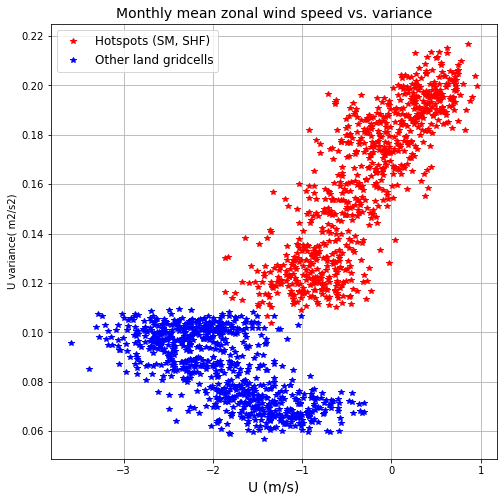

In [38]:
# Plot all in one?

fig, ax1 = plt.subplots(1,1, figsize=(8, 8))

# Plot scatter of gridcells classified as hotspots 
ax1.plot(U_hotspot_spaceMean, UP2_hotspot_spaceMean,'r*')
ax1.plot(U_other_spaceMean, UP2_other_spaceMean,'b*')
ax1.set_title('Monthly mean zonal wind speed vs. variance',fontsize=14)
ax1.set_xlabel('U (m/s)', fontsize=14)
ax1.set_ylabel('U variance( m2/s2)')
ax1.legend(['Hotspots (SM, SHF)', 'Other land gridcells'],fontsize=12)

ax1.grid()



## Look at vertical velocity too 

In [104]:
np.nanmean(WP2[:,1,:,:])

0.16688016

In [101]:
# --- Mask out portions of U and UP2 based on hotspots --- #

nT = np.shape(U)[0]     # Number of days to worry about 

# Defint empty arrays for masked data
W_hotspot   = np.full([nT, len(lat), len(lon)+1], np.nan) 
WP2_hotspot = np.full([nT, len(lat), len(lon)+1], np.nan)  
W_other     = np.full([nT, len(lat), len(lon)+1], np.nan) 
WP2_other   = np.full([nT, len(lat), len(lon)+1], np.nan) 

# Get U and UP2 as cyclic (since mask is based on that)
W_cyclic, lon_cyclic   = cartopy.util.add_cyclic_point(W[:,0,:,:], lon)
WP2_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(WP2[:,1,:,:], lon)

# Mask out data by day
for iT in range(nT):
    # Mask out gridcells not in hotspots 
    W_hotspot[iT,:,:]   = W_cyclic[iT,:,:]    * couplingMask_SMvSHF
    WP2_hotspot[iT,:,:] = WP2_cyclic[iT,:,:]  * couplingMask_SMvSHF 
    
    # Also select gridcells outside of hotspots
    W_other[iT,:,:]     = W_cyclic[iT,:,:]   * maskOther
    WP2_other[iT,:,:]   = WP2_cyclic[iT,:,:] * maskOther

# Average in space over hotspots or other land gridcells 
W_hotspot_spaceMean   = np.squeeze(np.nanmean(np.nanmean(W_hotspot,axis=1),axis=1)) 
WP2_hotspot_spaceMean = np.squeeze(np.nanmean(np.nanmean(WP2_hotspot,axis=1),axis=1)) 
W_other_spaceMean     = np.squeeze(np.nanmean(np.nanmean(W_other,axis=1),axis=1)) 
WP2_other_spaceMean   = np.squeeze(np.nanmean(np.nanmean(WP2_other,axis=1),axis=1)) 

# What if we average in time instead? 
W_hotspot_timeMean   = np.squeeze(np.nanmean(W_hotspot,axis=0)) 
WP2_hotspot_timeMean = np.squeeze(np.nanmean(WP2_hotspot,axis=0))  
W_other_timeMean     = np.squeeze(np.nanmean(W_other,axis=0)) 
WP2_other_timeMean   = np.squeeze(np.nanmean(WP2_other,axis=0))  


<ipython-input-101-32331b860e78>:26: RuntimeWarning: Mean of empty slice
  W_hotspot_spaceMean   = np.squeeze(np.nanmean(np.nanmean(W_hotspot,axis=1),axis=1))
<ipython-input-101-32331b860e78>:27: RuntimeWarning: Mean of empty slice
  WP2_hotspot_spaceMean = np.squeeze(np.nanmean(np.nanmean(WP2_hotspot,axis=1),axis=1))
<ipython-input-101-32331b860e78>:32: RuntimeWarning: Mean of empty slice
  W_hotspot_timeMean   = np.squeeze(np.nanmean(W_hotspot,axis=0))
<ipython-input-101-32331b860e78>:33: RuntimeWarning: Mean of empty slice
  WP2_hotspot_timeMean = np.squeeze(np.nanmean(WP2_hotspot,axis=0))
<ipython-input-101-32331b860e78>:34: RuntimeWarning: Mean of empty slice
  W_other_timeMean     = np.squeeze(np.nanmean(W_other,axis=0))
<ipython-input-101-32331b860e78>:35: RuntimeWarning: Mean of empty slice
  WP2_other_timeMean   = np.squeeze(np.nanmean(WP2_other,axis=0))


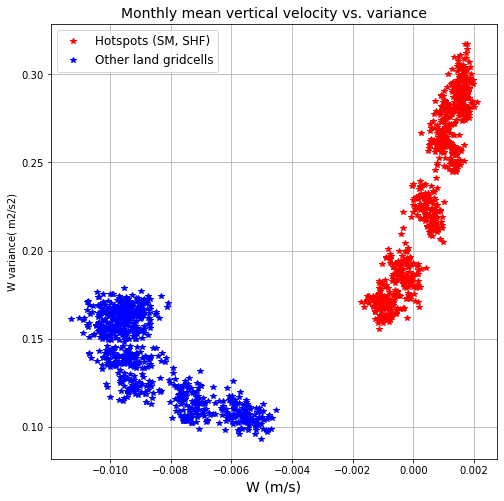

In [102]:
# Plot all in one?

fig, ax1 = plt.subplots(1,1, figsize=(8, 8))

# Plot scatter of gridcells classified as hotspots 
ax1.plot(W_hotspot_spaceMean, WP2_hotspot_spaceMean,'r*')
ax1.plot(W_other_spaceMean, WP2_other_spaceMean,'b*')
ax1.set_title('Monthly mean vertical velocity vs. variance',fontsize=14)
ax1.set_xlabel('W (m/s)', fontsize=14)
ax1.set_ylabel('W variance( m2/s2)')
ax1.legend(['Hotspots (SM, SHF)', 'Other land gridcells'],fontsize=12)

ax1.grid()



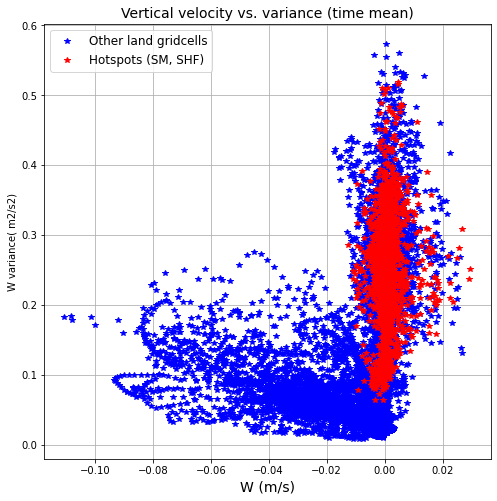

In [16]:
# How about if we look at means over time instead of space?
#   That means each dot is a gridcell instead of a monthly mean 

fig, ax1 = plt.subplots(1,1, figsize=(8, 8))

# Plot scatter of gridcells classified as hotspots 
ax1.plot(W_other_timeMean.reshape((len(lon)+1)*len(lat)), WP2_other_timeMean.reshape((len(lon)+1)*len(lat)), 'b*')
ax1.plot(W_hotspot_timeMean.reshape((len(lon)+1)*len(lat)), WP2_hotspot_timeMean.reshape((len(lon)+1)*len(lat)),'r*')
ax1.legend(['Other land gridcells','Hotspots (SM, SHF)'],fontsize=12)
ax1.set_title('Vertical velocity vs. variance (time mean)',fontsize=14)
ax1.set_xlabel('W (m/s)', fontsize=14)
ax1.set_ylabel('W variance( m2/s2)')

ax1.grid()




### Maps?

In [91]:
# Select levels of interest for U and UP2
W_sel   = W[:,0,:,:]
WP2_sel = WP2[:,1,:,:]

# Get std rather than variance 
Wstd_sel = np.sqrt(WP2_sel)

# Look at fraction of Wstd vs. magnitude of vertical velocity
STDfraction_sel = Wstd_sel / np.abs(W_sel)

# Take average over time for each grid point 
avgFraction_sel = np.nanmean(STDfraction_sel, axis=0)



In [95]:
np.nanmean(np.abs(W_sel))

0.003076379

In [96]:
np.nanmean(Wstd_sel)

0.38137177

Text(0.5, 1.0, 'std(W) / abs(W)')

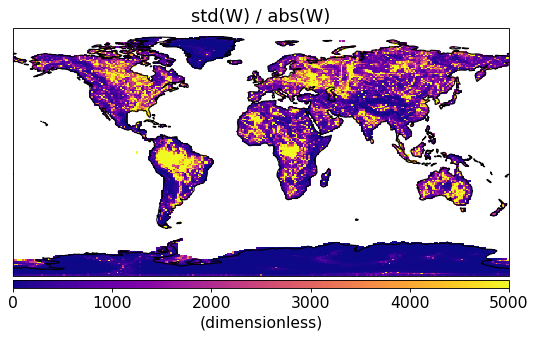

In [32]:
# Set up figure 
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax1.set_global()

# Make sure there's a cyclic point (otherwise you get a white line down the middle)
avgFraction_sel_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(avgFraction_sel, lon)

    
# Contour the (cyclic) field of interest 
contour_plot = ax1.pcolormesh(lon_cyclic,lat,avgFraction_sel_cyclic*landMask_cyclic,
                                    vmin=0,
                                    vmax=5000,
                                    cmap='plasma')

# Add continent outlines 
ax1.coastlines()
    
# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
#     # Control number of ticks via 'ticker' in matplotlib 
#     tick_locator = ticker.MaxNLocator(nbins=5)
#     cbar.locator = tick_locator
#     cbar.update_ticks()
# Set label and fontsize
cbar.set_label('(dimensionless)',fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Set plot title 
ax1.set_title('std(W) / abs(W)', fontsize=16)

# # Define some interesting regions 
# rect = patches.Rectangle((13,-9),22,19,linewidth=3,edgecolor='g',facecolor='none')    #Congo
# ax1.add_patch(rect)

# rect = patches.Rectangle((-105,26),27,18,linewidth=3,edgecolor='g',facecolor='none')  #Gulf coast
# ax1.add_patch(rect)

# # Pick out a few regions where it doesn't seem to be a big deal...
# rect = patches.Rectangle((-65,-9),27,18,linewidth=2,edgecolor='r',facecolor='none')  #Amazon-ish
# ax1.add_patch(rect)

# rect = patches.Rectangle((120,-33),27,16,linewidth=2,edgecolor='r',facecolor='none')  #Australia
# ax1.add_patch(rect)



## 2D histograms by season and region 

In [9]:
# Create 3D mask of the SRX regions 
RegMask = regionmask.defined_regions.srex.mask_3D(lon, lat)


In [11]:
# Get seasonal indices
iDJF = np.where((dates.month==1) | (dates.month<=3))[0]
iMAM = np.where((dates.month>=4) & (dates.month<=6))[0]
iJJA = np.where((dates.month>=7) & (dates.month<=9))[0]
iSON = np.where((dates.month>=10) & (dates.month<=12))[0]


In [28]:
# Average over seasons for specified U and UP2 levels 
U_seasons   = np.full([4, len(lat), len(lon)], np.nan)
UP2_seasons = np.full([4, len(lat), len(lon)], np.nan)

U_seasons[0,:,:] = np.nanmean(U.values[iDJF,0,:,:],axis=0)
U_seasons[1,:,:] = np.nanmean(U.values[iMAM,0,:,:],axis=0)
U_seasons[2,:,:] = np.nanmean(U.values[iJJA,0,:,:],axis=0)
U_seasons[3,:,:] = np.nanmean(U.values[iSON,0,:,:],axis=0)

UP2_seasons[0,:,:] = np.nanmean(UP2.values[iDJF,1,:,:],axis=0)
UP2_seasons[1,:,:] = np.nanmean(UP2.values[iMAM,1,:,:],axis=0)
UP2_seasons[2,:,:] = np.nanmean(UP2.values[iJJA,1,:,:],axis=0)
UP2_seasons[3,:,:] = np.nanmean(UP2.values[iSON,1,:,:],axis=0)



Now that we have seasonal averages, we want to look at just one region at a time. What does a 2D histogram look like between U and UP2 seasonally and regionally? 

In [46]:
np.linspace(-15,15,21)

array([-15. , -13.5, -12. , -10.5,  -9. ,  -7.5,  -6. ,  -4.5,  -3. ,
        -1.5,   0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,
        12. ,  13.5,  15. ])

In [ ]:
# Loop over regions... 
nRegions = len(RegMask.region.values)

# Set up bin edges for both vars
U_edges   = np.linspace(-15,15,21)
UP2_edges = np.linspace(0,1,21)

for iReg in range(nRegions): 
    rSel = RegMask.sel(region=iReg+1)
    
    # Select arrays seasonally 
    U_regSel_DJF = U[iDJF,0,:,:].where(rSel)
    U_regSel_MAM = U[iMAM,0,:,:].where(rSel)
    U_regSel_JJA = U[iJJA,0,:,:].where(rSel)
    U_regSel_SON = U[iSON,0,:,:].where(rSel)
    
    UP2_regSel_DJF = UP2[iDJF,1,:,:].where(rSel)
    UP2_regSel_MAM = UP2[iMAM,1,:,:].where(rSel)
    UP2_regSel_JJA = UP2[iJJA,1,:,:].where(rSel)
    UP2_regSel_SON = UP2[iSON,1,:,:].where(rSel)
        
    # Average over the season and flatten the arrays over space for these regions (histograms compute quicker)
    U_regSel_DJF = np.nanmean(U_regSel_DJF, axis=0).reshape([len(lon)*len(lat)])
    U_regSel_MAM = np.nanmean(U_regSel_MAM, axis=0).reshape([len(lon)*len(lat)])
    U_regSel_JJA = np.nanmean(U_regSel_JJA, axis=0).reshape([len(lon)*len(lat)])
    U_regSel_SON = np.nanmean(U_regSel_SON, axis=0).reshape([len(lon)*len(lat)])
    
    UP2_regSel_DJF = np.nanmean(UP2_regSel_DJF, axis=0).reshape([len(lon)*len(lat)])
    UP2_regSel_MAM = np.nanmean(UP2_regSel_MAM, axis=0).reshape([len(lon)*len(lat)])
    UP2_regSel_JJA = np.nanmean(UP2_regSel_JJA, axis=0).reshape([len(lon)*len(lat)])
    UP2_regSel_SON = np.nanmean(UP2_regSel_SON, axis=0).reshape([len(lon)*len(lat)])    
    
    # Get 2D hist info 
    H_reg_DJF, U_edges, UP2_edges = np.histogram2d(U_regSel_DJF, UP2_regSel_DJF, bins=(U_edges, UP2_edges))
    
    

In [47]:
iReg = 0
rSel = RegMask.sel(region=iReg+1)
U_regSel_DJF = U[iDJF,0,:,:].where(rSel)
UP2_regSel_DJF = UP2[iDJF,1,:,:].where(rSel)

U_regSel_DJF  = np.nanmean(U_regSel_DJF, axis=0).reshape([len(lon)*len(lat)])
UP2_regSel_DJF = np.nanmean(UP2_regSel_DJF, axis=0).reshape([len(lon)*len(lat)])


<ipython-input-47-052451289454>:6: RuntimeWarning: Mean of empty slice
  U_regSel_DJF = np.nanmean(U_regSel_DJF, axis=0).reshape([len(lon)*len(lat)])
<ipython-input-47-052451289454>:7: RuntimeWarning: Mean of empty slice
  UP2_regSel_DJF = np.nanmean(UP2_regSel_DJF, axis=0).reshape([len(lon)*len(lat)])


In [60]:
np.shape(U_regSel_DJF[np.isfinite(U_regSel_DJF)==True])

(663,)

In [81]:
# Set up edges 
U_edges   = np.linspace(-15,15,31)
UP2_edges = np.linspace(0,1,31)

# Get 2D hist info 
H_reg_DJF, U_edges, UP2_edges = np.histogram2d(U_regSel_DJF,
                                               UP2_regSel_DJF, 
                                               bins=(U_edges, UP2_edges))


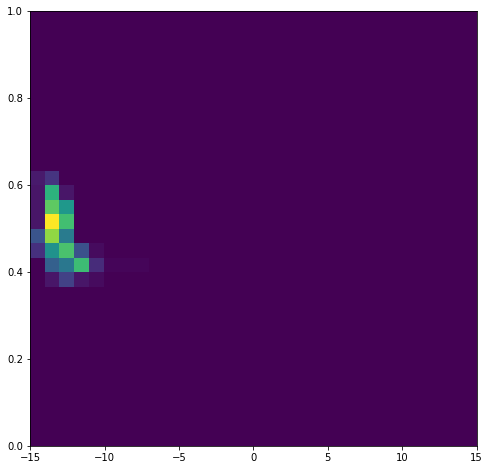

In [82]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))

X,Y = np.meshgrid(U_edges, UP2_edges)
ax.pcolormesh(X,Y, H_reg_DJF)
plt.show()